In [2]:
import numpy as np

from time import time
import sys
sys.path.append('/home/addis/unamed_code')
sys.path.append('/home/addis/unamed_code/Library')



# so the has theta binning endpoint approximation
import numpy as np
#from time import time # maybe add computation time feature
from itertools import combinations_with_replacement
import pickle
from numba import jit
import sys
sys.path.append('Library')
import base_funcs as bf

import get_field as gf
from matplotlib import pyplot as plt
import compute_grid_info as cgi

#field things!
path = '../data/Quijote/' #path to folder containing quijote files.
N_side = 128
rsd_direction = '' # 'z'

redshift = '/snapdir_004/snap_004'
if redshift[-1] == str(4):
    red_info = 'z=0'
elif redshift[-1] == str(2):
    red_info = 'z=1'
else:
    red_info = 'z=NA'

In [3]:
class Pk1:
    def __init__(self,delta,L,Nside,l,k,grid_info,binning_info,
                 t=0,iFFT=False,dtype=np.complex128,threads=1,rfft=False,verbose=True):
        
        #unpack variables from grid info and binning info...
        xi,ki,k_mag,MAS,k_f,k_ny = grid_info
        In_bin,N_modes = binning_info
        
        #raise warning if bad dtype
        if dtype != np.complex128 and dtype != np.complex64:
            raise Exception("Invalid dtype")
            
        N_side = len(delta)
        #import which fft type we want to use for the estimator
        #also sets some values in the case of real FFTs - i.e. fourier space arrays are halved
        if rfft:
            N_side_r = N_side//2 + 1                   #N_side changes in last axis for rffts
            if dtype == np.complex128:
                from FFTW import FFTW_irfft_double as iFFT_
                from FFTW import FFTW_rfft_double as FFT_       
                dtype_r = np.float64                            #dtype changes in real space for rffts
            elif dtype == np.complex64:
                from FFTW import FFTW_irfft_single as iFFT_
                from FFTW import FFTW_rfft_single as FFT_
                dtype_r = np.float32
        else:
            if dtype == np.complex128:
                from FFTW import FFTW_ifft_double as iFFT_
                from FFTW import FFTW_fft_double as FFT_         
            elif dtype == np.complex64:
                from FFTW import FFTW_ifft_single as iFFT_
                from FFTW import FFTW_fft_single as FFT_
            dtype_r = dtype                         
            N_side_r = N_side                       
        
        #initialize global variables
        #FFT_number=0;iFFT_number=0
        #wrapper function for FFT scheme imported from FFTW module - counts FFTs
        def FFTW_fft(delta):
            global FFT_number
            FFT_number += 1
            return FFT_(delta,threads)
        #wrapper function for iFFT scheme imported from FFTW module - counts iFFTs
        def FFTW_ifft(delta):
            global iFFT_number
            iFFT_number += 1
            return iFFT_(delta,threads)
        
                #Caluclate Q_ij etc and sums over to get G - without summing Qpqrs2 (i.e.  requires a lot more memory...
        
        #so this is for the q1.r1 parts
        def Qpqrs(delta,xi,ki,l): # extends
            if l == 0:
                return FFTW_fft(delta) # this is need for the way Pk_bisector is implemented

            kQ_sum = np.zeros((N_side,N_side,N_side_r)) # create empty array

            ind = np.array(list(combinations_with_replacement(np.arange(3), l))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            for i in ind: # so iterates for each possible ij etc

                k_prod = np.prod(ki[i],axis=0) # sum kx etc arrays for each combination
                x_prod = np.prod(xi[i],axis=0) #real parts
                #count distinct permutation for each combination
                kQ_sum = np.add(kQ_sum,np.multiply(bf.count_distinct_permutations(i)*k_prod,FFTW_fft(delta*x_prod),dtype=dtype)) # e.g. all terms in square brackets eq.20 scoccimarro

            return kQ_sum
                    
        
        #calculates Pk using a direct estimator method - midpoint so just doesn't use iFFTs
        def Pk_main(delta,k_,l):
            global FFT_number
            FFT_number = 0

            delta_k = FFTW_fft(delta) #no longer in get values
            Npix = Nside**3
            V = L**3
            H = V/Npix
            const = (H**2)/V
            
            Nbins = len(k_)
            #ok so like bispectrum but should have a lot fewer moving parts - go down from 3 to 2 
            def main_func(l):
                if l == 0:
                    return Pk_mono
                
                ind = np.array(list(combinations_with_replacement(np.arange(2), l))) #find all combinations for l components from x,y,z
                Pk_lm = np.zeros(Nbins,dtype=dtype)
                #ok instead of doing that lets just save the A_{mn} etc 
                Amn = {}
                for i in range(0,len(ind)): # so iterates for each possible Amn etc   #proper stuff begins here
                    f123 = np.array([np.sum(ind[i]==0),np.sum(ind[i]==1)]) #m and n coefficients
                    
                    #calculate t stuff
                    coef = ((1-t)**(f123[0]))*(t)**(f123[1])
                    """if coef==0: # we always want to compute A_mn where m>n as it's more efficient
                        print('coef=',coef)
                        continue #skip zero terms"""#this isn't necessary as the saved computation will be in the next paragraph
                    
                    #so we want to do the simplest calculation where m>n
                    f123_efficient = np.sort(f123)[::-1] # so we do this with the bins of f123
                    if tuple(f123_efficient) in Amn.keys(): #if already precomputed...
                        print("Not computing $A_{{{}{}}}$".format(f123[0], f123[1]))#print('not computing->',f123)
                        if f123_efficient[0] == f123[0]:  #this will never be true for pk case
                            Pk_lm += coef*Amn[tuple(f123_efficient)] #use precomputed Amn 
                        else:
                            Pk_lm += coef*np.conj(Amn[tuple(f123_efficient)])
                        continue #don't compute again!
                    
                    #get the two fields Q_m and Q_n etc - for second field k2 = -k1 which we are expanding around    
                    F_1 = Qpqrs(delta,xi,ki,f123[0])*MAS
                    F_2 = Qpqrs(delta,-xi,ki,f123[1])*MAS#(-1)**(f123[1]) is there as we have negative k for second field

                    #print('Acomuting->',"A_{%d%d}'%(f123[0],f123[1]))
                    Amn[tuple(f123)]=np.zeros(Nbins,dtype=dtype)

                    power_k = F_1*np.conj(F_2)#*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                    #power_bin = np.sum(power_k[np.newaxis, ...] * In_bin, axis=(1,2,3))
                    #Amn[tuple(f123)] = power_bin/N_modes#save Amnp
                    for j in range(len(k_)):
                        power_bin = np.sum(power_k[In_bin[j]])
                        Amn[tuple(f123)][j] += power_bin/N_modes[j]#save Amnp

                    Amn[tuple(f123)] *= const*bf.cdp_f123(f123)
                    Pk_lm += coef*Amn[tuple(f123)]

                return Pk_lm

            def Pk_legendre(l):
                if l == 0:
                    return main_func(0)
                if l == 1:
                    return main_func(1)
                if l == 2:
                    return (1/2)*(3*main_func(2)-main_func(0))
                if l == 3:
                    return (1/2)*(5*main_func(3)- 3*main_func(1))
                if l == 4:
                    return (1/8)*(35*main_func(4)- 30*main_func(2) + 3*main_func(0))
                else:
                    raise "Multipole not implemented"

            Pk_lm = Pk_legendre(l)
            return (2*l+1)*(Pk_lm)
        
        #calculates Pk using a direct estimator method - endpoint version
        def Pk_endpoint(delta,k,l):
            global FFT_number
            FFT_number = 0
            
            #Lengendre multipoles
            def delta_lm(delta_x,delta_k,xi,ki,l):  #convolves delta with legendre polynomial
                if l == 0:
                    return delta_k
                if l==1:
                    Q_x = Qpqrs(delta_x,xi,ki,l)
                    return Q_x
                if l==2:
                    Q_xx = Qpqrs(delta_x,xi,ki,l)
                    return (3/2)*Q_xx - (1/2)*delta_k
                if l==3:
                    Q_xx = Qpqrs(delta_x,xi,ki,l)
                    return (1/2)*(5*Q_xx - 3*delta_lm(delta_x,delta_k,xi,ki,1))
                if l==4:
                    Q_xxxx = Qpqrs(delta_x,xi,ki,l)
                    return (35/8)*Q_xxxx - (5/2)*delta_lm(delta_x,delta_k,xi,ki,2) - (7/8)*delta_k
                else:
                    raise Exception(l,"l-multipole not implemented")
                    
            delta_k = FFTW_fft(delta)
            
            #calculate convolved field.
            delta_l = delta_lm(delta,delta_k,xi,ki,l)*MAS #this is the delta_l #plane_parallel
            delta_kk = delta_k*MAS

            Npix = Nside**3
            V = L**3
            H = V/Npix
            const = (H**2)/V

            Pk = np.zeros(len(k),dtype=dtype)
            power_k = delta_l*np.conj(delta_kk)#has to be conjugate as this creates the other part from from rfft - so if you consider full fft then we get double N_modes and Power_bin which cancels
            for i in range(len(k)):
                power_bin = np.sum(power_k[In_bin[i]])
                Pk[i] = const*power_bin/N_modes[i]
            return (2*l+1)*Pk
        

        #throw this in for efficiency
        if iFFT == True:
            Pk_mono = FFTPS(delta,L,k,0,mas_order,s,z_off,x_off,y_off,False)
            self.mono = Pk_mono

            if t==0 or t==1:
                self.pk = Pk_t(delta,L,k,l,mas_order,s,real,z_off,x_off,y_off,verbose)
            else:
                self.pk = FFTPS(delta,L,k,l,mas_order,s,z_off,x_off,y_off,verbose)
                
        else:
            Pk_mono = Pk_endpoint(delta,k,0)
            self.mono = Pk_mono
            if l==0:
                self.pk = Pk_mono
                    
            else:
                if t == 0:
                    self.pk = Pk_endpoint(delta,k,l)
                else:
                    self.pk = Pk_main(delta,k,l)

In [10]:
class Pk:
    def __init__(self,delta,L,Nside,l,k,grid_info,binning_info,
                 t=0,iFFT=False,dtype=np.complex128,threads=1,rfft=False,verbose=True):
        
        #unpack variables from grid info and binning info...
        xi,x_norm,ki,k_mag,MAS,k_f,k_ny = grid_info
        In_bin,N_modes = binning_info
        xi = xi/x_norm
        #raise warning if bad dtype
        if dtype != np.complex128 and dtype != np.complex64:
            raise Exception("Invalid dtype")
            
        N_side = len(delta)
        #import which fft type we want to use for the estimator
        #also sets some values in the case of real FFTs - i.e. fourier space arrays are halved
        if rfft:
            N_side_r = N_side//2 + 1                   #N_side changes in last axis for rffts
            if dtype == np.complex128:
                from FFTW import FFTW_irfft_double as iFFT_
                from FFTW import FFTW_rfft_double as FFT_       
                dtype_r = np.float64                            #dtype changes in real space for rffts
            elif dtype == np.complex64:
                from FFTW import FFTW_irfft_single as iFFT_
                from FFTW import FFTW_rfft_single as FFT_
                dtype_r = np.float32
        else:
            if dtype == np.complex128:
                from FFTW import FFTW_ifft_double as iFFT_
                from FFTW import FFTW_fft_double as FFT_         
            elif dtype == np.complex64:
                from FFTW import FFTW_ifft_single as iFFT_
                from FFTW import FFTW_fft_single as FFT_
            dtype_r = dtype                         
            N_side_r = N_side                       
        
        #initialize global variables
        #FFT_number=0;iFFT_number=0
        #wrapper function for FFT scheme imported from FFTW module - counts FFTs
        def FFTW_fft(delta):
            global FFT_number
            FFT_number += 1
            return FFT_(delta,threads)
        #wrapper function for iFFT scheme imported from FFTW module - counts iFFTs
        def FFTW_ifft(delta):
            global iFFT_number
            iFFT_number += 1
            return iFFT_(delta,threads)
        
                #Caluclate Q_ij etc and sums over to get G - without summing Qpqrs2 (i.e.  requires a lot more memory...
        #so this is for the q1.r1 parts
        def Qpqrs(delta,xi,ki,l): # extends
            if l == 0:
                return FFTW_fft(delta) # this is need for the way Pk_bisector is implemented

            kQ_sum = np.zeros((N_side,N_side,N_side_r)) # create empty array

            ind = np.array(list(combinations_with_replacement(np.arange(3), l))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            for i in ind: # so iterates for each possible ij etc

                k_prod = np.prod(ki[i],axis=0) # sum kx etc arrays for each combination
                x_prod = np.prod(xi[i],axis=0) #real parts
                #count distinct permutation for each combination
                kQ_sum = np.add(kQ_sum,np.multiply(bf.count_distinct_permutations(i)*k_prod,FFTW_fft(delta*x_prod),dtype=dtype)) # e.g. all terms in square brackets eq.20 scoccimarro

            return kQ_sum
        
        #calculates Pk using a direct estimator method - midpoint so just doesn't use iFFTs
        def Pk_main(delta,k_,l):
            global FFT_number
            FFT_number = 0

            delta_k = FFTW_fft(delta) #no longer in get values
            Npix = Nside**3
            V = L**3
            H = V/Npix
            const = (H**2)/V

            Nbins = len(k_)
            #ok so like bispectrum but should have a lot fewer moving parts - go down from 3 to 2 
            def main_func(l):
                if l == 0:
                    return Pk_mono
                
                ind = np.array(list(combinations_with_replacement(np.arange(2), l))) #find all combinations for l components from x,y,z
                Pk_lm = np.zeros(Nbins,dtype=dtype)
                #ok instead of doing that lets just save the A_{mn} etc 
                Amn = {}
                for i in range(0,len(ind)): # so iterates for each possible Amn etc   #proper stuff begins here
                    f123 = np.array([np.sum(ind[i]==0),np.sum(ind[i]==1)]) #m and n coefficients
                    
                    #calculate t stuff
                    coef = ((1-t)**(f123[0]))*(t)**(f123[1])
                    
                    #so we want to do the simplest calculation where m>n
                    f123_efficient = np.sort(f123)[::-1] # so we do this with the bins of f123
                    if tuple(f123_efficient) in Amn.keys(): #if already precomputed...
                        print("Not computing $A_{{{}{}}}$".format(f123[0], f123[1]))#print('not computing->',f123)
                        if f123_efficient[0] == f123[0]:  #this will never be true for pk case
                            Pk_lm += coef*Amn[tuple(f123_efficient)] #use precomputed Amn 
                        else:
                            Pk_lm += coef*np.conj(Amn[tuple(f123_efficient)])
                        continue #don't compute again!
                    
                    #get the two fields Q_m and Q_n etc - for second field k2 = -k1 which we are expanding around    
                    F_1 = Qpqrs(delta,xi,ki,f123[0])*MAS
                    F_2 = Qpqrs(delta,xi,ki,f123[1])*MAS#(-1)**(f123[1]) is there as we have negative k for second field

                    #print('Acomuting->',"A_{%d%d}'%(f123[0],f123[1]))
                    Amn[tuple(f123)]=np.zeros(Nbins,dtype=dtype)

                    power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                    #power_bin = np.sum(power_k[np.newaxis, ...] * In_bin, axis=(1,2,3))
                    #Amn[tuple(f123)] = power_bin/N_modes#save Amnp
                    for j in range(len(k_)):
                        power_bin = np.sum(power_k[In_bin[j]])
                        Amn[tuple(f123)][j] += power_bin/N_modes[j]#save Amnp

                    Amn[tuple(f123)] *= const*bf.cdp_f123(f123)
                    Pk_lm += coef*Amn[tuple(f123)]

                return Pk_lm

            def Pk_legendre(l):
                if l == 0:
                    return main_func(0)
                if l == 1:
                    return main_func(1)
                if l == 2:
                    return (1/2)*(3*main_func(2)-main_func(0))
                if l == 3:
                    return (1/2)*(5*main_func(3)- 3*main_func(1))
                if l == 4:
                    return (1/8)*(35*main_func(4)- 30*main_func(2) + 3*main_func(0))
                else:
                    raise "Multipole not implemented"

            Pk_lm = Pk_legendre(l)
            return (2*l+1)*(Pk_lm)
        
        #calculates Pk using a direct estimator method - endpoint version
        def Pk_endpoint(delta,k,l):
            global FFT_number
            FFT_number = 0
            
            #Lengendre multipoles
            def delta_lm(delta_x,delta_k,xi,ki,l):  #convolves delta with legendre polynomial
                if l == 0:
                    return delta_k
                if l==1:
                    Q_x = Qpqrs(delta_x,xi,ki,l)
                    return Q_x
                if l==2:
                    Q_xx = Qpqrs(delta_x,xi,ki,l)
                    return (3/2)*Q_xx - (1/2)*delta_k
                if l==3:
                    Q_xx = Qpqrs(delta_x,xi,ki,l)
                    return (1/2)*(5*Q_xx - 3*delta_lm(delta_x,delta_k,xi,ki,1))
                if l==4:
                    Q_xxxx = Qpqrs(delta_x,xi,ki,l)
                    return (35/8)*Q_xxxx - (5/2)*delta_lm(delta_x,delta_k,xi,ki,2) - (7/8)*delta_k
                else:
                    raise Exception(l,"l-multipole not implemented")
                    
            delta_k = FFTW_fft(delta)
            
            #calculate convolved field.
            delta_l = delta_lm(delta,delta_k,xi,ki,l)*MAS #this is the delta_l #plane_parallel
            delta_kk = delta_k*MAS

            Npix = Nside**3
            V = L**3
            H = V/Npix
            const = (H**2)/V

            Pk = np.zeros(len(k),dtype=dtype)
            power_k = delta_l*np.conj(delta_kk)#has to be conjugate as this creates the other part from from rfft - so if you consider full fft then we get double N_modes and Power_bin which cancels
            for i in range(len(k)):
                power_bin = np.sum(power_k[In_bin[i]])
                Pk[i] = const*power_bin/N_modes[i]
            return (2*l+1)*Pk
        

        #throw this in for efficiency
        if iFFT == True:
            Pk_mono = FFTPS(delta,L,k,0,mas_order,s,z_off,x_off,y_off,False)
            self.mono = Pk_mono

            if t==0 or t==1:
                self.pk = Pk_t(delta,L,k,l,mas_order,s,real,z_off,x_off,y_off,verbose)
            else:
                self.pk = FFTPS(delta,L,k,l,mas_order,s,z_off,x_off,y_off,verbose)
                
        else:
            Pk_mono = Pk_endpoint(delta,k,0)
            self.mono = Pk_mono
            if l==0:
                self.pk = Pk_mono
                    
            else:
                if t == 0:
                    self.pk = Pk_endpoint(delta,k,l)
                else:
                    self.pk = Pk_main(delta,k,l)

In [5]:
class Pk_new:
    def __init__(self,delta,L,Nside,l,k,grid_info,binning_info,
                 t=0,ex_order=1,iFFT=False,dtype=np.complex128,threads=1,rfft=False,verbose=True):
        
        #unpack variables from grid info and binning info...
        xi,x_norm,ki,k_mag,MAS,k_f,k_ny = grid_info
        In_bin,N_modes = binning_info
        print(In_bin.shape)
        #raise warning if bad dtype
        if dtype != np.complex128 and dtype != np.complex64:
            raise Exception("Invalid dtype")
            
        N_side = len(delta)
        #import which fft type we want to use for the estimator
        #also sets some values in the case of real FFTs - i.e. fourier space arrays are halved
        if rfft:
            N_side_r = N_side//2 + 1                   #N_side changes in last axis for rffts
            if dtype == np.complex128:
                from FFTW import FFTW_irfft_double as iFFT_
                from FFTW import FFTW_rfft_double as FFT_       
                dtype_r = np.float64                            #dtype changes in real space for rffts
            elif dtype == np.complex64:
                from FFTW import FFTW_irfft_single as iFFT_
                from FFTW import FFTW_rfft_single as FFT_
                dtype_r = np.float32
        else:
            if dtype == np.complex128:
                from FFTW import FFTW_ifft_double as iFFT_
                from FFTW import FFTW_fft_double as FFT_         
            elif dtype == np.complex64:
                from FFTW import FFTW_ifft_single as iFFT_
                from FFTW import FFTW_fft_single as FFT_
            dtype_r = dtype                         
            N_side_r = N_side                       
        
        #initialize global variables
        #FFT_number=0;iFFT_number=0
        #wrapper function for FFT scheme imported from FFTW module - counts FFTs
        def FFTW_fft(delta):
            global FFT_number
            FFT_number += 1
            return FFT_(delta,threads)
        #wrapper function for iFFT scheme imported from FFTW module - counts iFFTs
        def FFTW_ifft(delta):
            global iFFT_number
            iFFT_number += 1
            return iFFT_(delta,threads)
        
                #Caluclate Q_ij etc and sums over to get G - without summing Qpqrs2 (i.e.  requires a lot more memory...
        #so this is for the q1.r1 parts
        def Qpqrs(delta,xi,ki,l): # extends
            if l == 0:
                return FFTW_fft(delta) # this is need for the way Pk_bisector is implemented

            kQ_sum = np.zeros((N_side,N_side,N_side_r)) # create empty array

            ind = np.array(list(combinations_with_replacement(np.arange(3), l))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            for i in ind: # so iterates for each possible ij etc

                k_prod = np.prod(ki[i],axis=0) # sum kx etc arrays for each combination
                x_prod = np.prod(xi[i],axis=0) #real parts
                #count distinct permutation for each combination
                kQ_sum = np.add(kQ_sum,np.multiply(bf.count_distinct_permutations(i)*k_prod,FFTW_fft(delta*x_prod),dtype=dtype)) # e.g. all terms in square brackets eq.20 scoccimarro

            return kQ_sum
        
        """
        #ok so need a function that for each multipole then computes different xi and ki
        #-t x1 (x1.x2)/x1
        def Fields_func(delta,k1,xi,x_norm,l): # extends
            F_1 = np.zeros((3,N_side,N_side,N_side_r),dtype=np.complex128) # create empty array
            F_2 = np.zeros((3,N_side,N_side,N_side_r),dtype=np.complex128) # create empty array
            #for the dot products if they to a power...
            ind = np.array(list(combinations_with_replacement(np.arange(3), l))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            
            for i in range(3): # so iterates for each possible ij etc # this for x1.x2 part
                x_prod12 = xi[i]#np.prod(x2[i],axis=0) #so this second dot product
                #bf.count_distinct_permutations(i)*
                F_2[i] = FFTW_fft(delta*x_prod12) # e.g. all terms in square brackets eq.20 scoccimarro
                for j in ind: #for k1.x1 part
                    k_prod = np.prod(k1[j],axis=0) # sum kx etc arrays for each combination
                    x_prod = np.prod(xi[j]/x_norm,axis=0) #real parts
                    
                    #count distinct permutation for each combination
                    F_1[i] += bf.count_distinct_permutations(j)*k_prod*FFTW_fft(delta*x_prod*x_prod12/x_norm**2) # e.g. all terms in square brackets eq.20 scoccimarro
                    
            return F_1,F_2"""
        
        # (k1.x_{field})^l1 (x1.x2)^l2
        def Fields_func(delta,k1,xi,x_norm,l1,l2,field=1):
            #for the two cartesian expansions
            ind1 = np.array(list(combinations_with_replacement(np.arange(3), l1))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            ind2 = np.array(list(combinations_with_replacement(np.arange(3), l2))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
   
            F_1 = np.zeros((len(ind2),N_side,N_side,N_side_r),dtype=np.complex128) # create empty array
            F_2 = np.zeros((len(ind2),N_side,N_side,N_side_r),dtype=np.complex128) # create empty array

            delta1 = delta*1  #assign fields
            delta2 = delta*1
            if field == 2:
                delta2 *= 1/(x_norm**(l1+2*l2))
            else:
                delta1 *= 1/(x_norm**(l1+2*l2))
            
            # so iterates for each possible ij etc   
            for i in range(len(ind2)):  # this for x1.x2 part
                x_prod2 = np.prod(xi[ind2[i]],axis=0)
                F_2[i] = bf.count_distinct_permutations(ind2[i])*FFTW_fft(delta2*x_prod2) # e.g. all terms in square brackets eq.20 scoccimarro
                for j in ind1: #for k1.x1 part #this is then condensed...
                    k_prod = np.prod(k1[j],axis=0) # sum kx etc arrays for each combination
                    x_prod = np.prod(xi[j],axis=0) #sum xi etc
                    F_1[i] += bf.count_distinct_permutations(j)*k_prod*FFTW_fft(delta1*x_prod*x_prod2) # e.g. all terms in square brackets eq.20 scoccimarro
                    
            return F_1,F_2
        
        #ok so need a function that for each multipole then computes different xi and ki
        def Qpqrs(delta,xi,ki,l): # extends
            if l == 0:
                return FFTW_fft(delta) # this is need for the way Pk_bisector is implemented

            kQ_sum = np.zeros((N_side,N_side,N_side_r)) # create empty array

            ind = np.array(list(combinations_with_replacement(np.arange(3), l))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            for i in ind: # so iterates for each possible ij etc

                k_prod = np.prod(ki[i],axis=0) # sum kx etc arrays for each combination
                x_prod = np.prod(xi[i],axis=0) #real parts
                #count distinct permutation for each combination
                kQ_sum = np.add(kQ_sum,np.multiply(bf.count_distinct_permutations(i)*k_prod,FFTW_fft(delta*x_prod),dtype=dtype)) # e.g. all terms in square brackets eq.20 scoccimarro

            return kQ_sum
        
        
        #calculates Pk using a direct estimator method - midpoint so just doesn't use iFFTs
        def Pk_main(delta,k_,l):
            global FFT_number
            FFT_number = 0

            delta_k = FFTW_fft(delta) #no longer in get values
            Npix = Nside**3
            V = L**3
            H = V/Npix
            const = (H**2)/V
            
            Nbins = len(k_)
            def main_func(l):
                Pk_lm = np.zeros(Nbins,dtype=dtype)
                Pk_lm1 = np.zeros(Nbins,dtype=dtype)
                Pk_lm2 = np.zeros(Nbins,dtype=dtype)
                Pk_lm3 = np.zeros(Nbins,dtype=dtype)
                Pk_lm4 = np.zeros(Nbins,dtype=dtype)
                Pk_lm5 = np.zeros(Nbins,dtype=dtype)
                if l == 0:
                    return Pk_mono

                if l==1:
                    #get the two fields Q_m and Q_n etc - for second field k2 = -k1 which we are expanding around    
                    F_1 = Qpqrs(delta,xi/x_norm,ki,1)*MAS
                    F_2 = delta_k*MAS  #(-1)**(f123[1]) is there as we have negative k for second field

                    power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                    #power_bin = np.sum(power_k[np.newaxis, ...] * In_bin, axis=(1,2,3))
                    for j in range(len(k_)):
                        power_bin = np.sum(power_k[In_bin[j]])
                        Pk_lm[j] += const*power_bin/N_modes[j]
                    
                    
                    if t > 0:
                        if ex_order ==1:
                            #t k.x2/x1
                            F_1 = FFTW_fft(delta/x_norm)*MAS#Qpqrs(delta,norm,ki,1)
                            F_2 = Qpqrs(delta,xi,ki,1)*MAS#so this has the k term...

                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            #power_bin = np.sum(power_k[np.newaxis, ...] * In_bin, axis=(1,2,3))
                            for j in range(len(k_)):
                                power_bin = t*np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += const*power_bin/N_modes[j]

                            #ok so -t(k1.x1)(x1.x2) #so there are 9 terms -(first 3 are collasped down)...
                            F_1,F_2 = Fields_func(delta,ki,xi,x_norm,1,1)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))  #power_bin = np.sum(power_k[np.newaxis, ...] * In_bin, axis=(1,2,3))
                            for i in range(3):
                                for j in range(len(k_)):
                                    power_bin = -t*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]

                        else:
                            #lets go to second order...
                            #only thing that changes for 1st few terms is (t**2+t)
                            #(t^2+t) k.x2/x1
                            F_1 = FFTW_fft(delta/x_norm)*MAS#Qpqrs(delta,norm,ki,1)
                            F_2 = Qpqrs(delta,xi,ki,1)*MAS#so this has the k term...
                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            for j in range(len(k_)):
                                power_bin = (t**2+t)*np.sum(power_k[In_bin[j]])
                                Pk_lm1[j] += const*power_bin/N_modes[j]
                                
                            #ok so -(t^2+t)(k1.x1)(x1.x2) #so there are 9 terms -(first 3 are collasped down)...
                            F_1,F_2 = Fields_func(delta,ki,xi,x_norm,1,1)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))
                            for i in range(3):
                                for j in range(len(k_)):
                                    power_bin = -(t**2+t)*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm2[j] += const*power_bin/N_modes[j]
                            
                            #-(t^2)(k1.x2)(x1.x2)
                            F_2,F_1 = Fields_func(delta,ki,xi,x_norm,1,1,2) # when field =2 then F_2 and F_1 switch
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))
                            for i in range(3):
                                for j in range(len(k_)):
                                    power_bin = -(t**2)*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm3[j] += const*power_bin/N_modes[j]
                                    
                            #3/2 (t^2)(k1.x1)(x1.x2)^2
                            F_1,F_2 = Fields_func(delta,ki,xi,x_norm,1,2)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (6,(field))
                            for i in range(6):
                                for j in range(len(k_)):
                                    power_bin = (3/2)*(t**2)*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm4[j] += const*power_bin/N_modes[j]
                                            
                            #-1/2 (t^2)(k1.x1)(x2.x2)
                            F_1 = Qpqrs(delta,xi/x_norm**3,ki,1)*MAS#so this has the k term...
                            F_2 = FFTW_fft(delta*x_norm**2)*MAS
                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            for j in range(len(k_)):
                                power_bin = -(1/2)*(t**2)*np.sum(power_k[In_bin[j]])
                                Pk_lm5[j] += const*power_bin/N_modes[j]
                
                            
                if l==2:
                    #get the two fields Q_m and Q_n etc - for second field k2 = -k1 which we are expanding around    
                    F_1 = Qpqrs(delta,xi/x_norm,ki,2)*MAS
                    F_2 = delta_k*MAS  #(-1)**(f123[1]) is there as we have negative k for second field
                    power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                    for j in range(len(k_)):
                        power_bin = np.sum(power_k[In_bin[j]])
                        Pk_lm[j] += const*power_bin/N_modes[j]
                        
                    if t > 0:
                        #2t (k.x1)(k.x2)/x1
                        F_1 = Qpqrs(delta,xi/x_norm**2,ki,1)*MAS
                        F_2 = Qpqrs(delta,xi,ki,1)*MAS

                        power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                        #power_bin = np.sum(power_k[np.newaxis, ...] * In_bin, axis=(1,2,3))
                        for j in range(len(k_)):
                            power_bin = 2*t*np.sum(power_k[In_bin[j]])
                            Pk_lm[j] += const*power_bin/N_modes[j]
                        
                        #-2t(k.x1)^2 (x1.x2)/x2
                        F_1,F_2 = Fields_func(delta,ki,xi,x_norm,2,1)
                        power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                        #ok F_1 and F_2 have shape (3,(field))  #power_bin = np.sum(power_k[np.newaxis, ...] * In_bin, axis=(1,2,3))
                        for i in range(3):
                            for j in range(len(k_)):
                                power_bin = -2*t*np.sum(power_k[i][In_bin[j]])
                                Pk_lm[j] += const*power_bin/N_modes[j]
                
                
                return np.array([Pk_lm,Pk_lm1,Pk_lm2,Pk_lm3,Pk_lm4,Pk_lm5])

            def Pk_legendre(l):
                if l == 0:
                    return main_func(0)
                if l == 1:
                    return main_func(1)
                if l == 2:
                    return (1/2)*(3*main_func(2)-main_func(0))
                if l == 3:
                    return (1/2)*(5*main_func(3)- 3*main_func(1))
                if l == 4:
                    return (1/8)*(35*main_func(4)- 30*main_func(2) + 3*main_func(0))
                else:
                    raise "Multipole not implemented"
            
            Pk_lm = Pk_legendre(l)
            return (2*l+1)*(Pk_lm)
        
        #calculates Pk using a direct estimator method - endpoint version
        def Pk_endpoint(delta,k,l):
            global FFT_number
            FFT_number = 0
            
            #Lengendre multipoles
            def delta_lm(delta_x,delta_k,xi,ki,l):  #convolves delta with legendre polynomial
                if l == 0:
                    return delta_k
                if l==1:
                    Q_x = Qpqrs(delta_x,xi,ki,l)
                    return Q_x
                if l==2:
                    Q_xx = Qpqrs(delta_x,xi,ki,l)
                    return (3/2)*Q_xx - (1/2)*delta_k
                if l==3:
                    Q_xx = Qpqrs(delta_x,xi,ki,l)
                    return (1/2)*(5*Q_xx - 3*delta_lm(delta_x,delta_k,xi,ki,1))
                if l==4:
                    Q_xxxx = Qpqrs(delta_x,xi,ki,l)
                    return (35/8)*Q_xxxx - (5/2)*delta_lm(delta_x,delta_k,xi,ki,2) - (7/8)*delta_k
                else:
                    raise Exception(l,"l-multipole not implemented")
                    
            delta_k = FFTW_fft(delta)
                    
                    
            #calculate convolved field.
            delta_l = delta_lm(delta,delta_k,xi,ki,l)*MAS #this is the delta_l #plane_parallel
            delta_kk = delta_k*MAS

            Npix = Nside**3
            V = L**3
            H = V/Npix
            const = (H**2)/V

            Pk = np.zeros(len(k),dtype=dtype)
            power_k = delta_l*np.conj(delta_kk)#has to be conjugate as this creates the other part from from rfft - so if you consider full fft then we get double N_modes and Power_bin which cancels
            for i in range(len(k)):
                power_bin = np.sum(power_k[In_bin[i]])
                Pk[i] = const*power_bin/N_modes[i]
            return (2*l+1)*Pk
        
        Pk_mono = Pk_endpoint(delta,k,0)
        self.mono = Pk_mono

        self.pk = Pk_main(delta,k,l)

In [15]:
class Pk_new1:
    def __init__(self,delta,L,Nside,l,k,grid_info,binning_info,
                 t=0,ex_order=1,iFFT=False,dtype=np.complex128,threads=1,rfft=False,verbose=True):
        
        #unpack variables from grid info and binning info...
        xi,x_norm,ki,k_mag,MAS,k_f,k_ny = grid_info
        In_bin,N_modes = binning_info

        #raise warning if bad dtype
        if dtype != np.complex128 and dtype != np.complex64:
            raise Exception("Invalid dtype")
            
        N_side = len(delta)
        #import which fft type we want to use for the estimator
        #also sets some values in the case of real FFTs - i.e. fourier space arrays are halved
        if rfft:
            N_side_r = N_side//2 + 1                   #N_side changes in last axis for rffts
            if dtype == np.complex128:
                from FFTW import FFTW_irfft_double as iFFT_
                from FFTW import FFTW_rfft_double as FFT_       
                dtype_r = np.float64                            #dtype changes in real space for rffts
            elif dtype == np.complex64:
                from FFTW import FFTW_irfft_single as iFFT_
                from FFTW import FFTW_rfft_single as FFT_
                dtype_r = np.float32
        else:
            if dtype == np.complex128:
                from FFTW import FFTW_ifft_double as iFFT_
                from FFTW import FFTW_fft_double as FFT_         
            elif dtype == np.complex64:
                from FFTW import FFTW_ifft_single as iFFT_
                from FFTW import FFTW_fft_single as FFT_
            dtype_r = dtype                         
            N_side_r = N_side                       
        
        #initialize global variables
        #FFT_number=0;iFFT_number=0
        #wrapper function for FFT scheme imported from FFTW module - counts FFTs
        def FFTW_fft(delta):
            global FFT_number
            FFT_number += 1
            return FFT_(delta,threads)
        #wrapper function for iFFT scheme imported from FFTW module - counts iFFTs
        def FFTW_ifft(delta):
            global iFFT_number
            iFFT_number += 1
            return iFFT_(delta,threads)
        
                #Caluclate Q_ij etc and sums over to get G - without summing Qpqrs2 (i.e.  requires a lot more memory...
        #so this is for the q1.r1 parts
        def Qpqrs(delta,xi,ki,l): # extends
            if l == 0:
                return FFTW_fft(delta) # this is need for the way Pk_bisector is implemented

            kQ_sum = np.zeros((N_side,N_side,N_side_r)) # create empty array

            ind = np.array(list(combinations_with_replacement(np.arange(3), l))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            for i in ind: # so iterates for each possible ij etc

                k_prod = np.prod(ki[i],axis=0) # sum kx etc arrays for each combination
                x_prod = np.prod(xi[i],axis=0) #real parts
                #count distinct permutation for each combination
                kQ_sum = np.add(kQ_sum,np.multiply(bf.count_distinct_permutations(i)*k_prod,FFTW_fft(delta*x_prod),dtype=dtype)) # e.g. all terms in square brackets eq.20 scoccimarro

            return kQ_sum
   
        # (k1.x_{field})^l1 (x1.x2)^l2
        def Fields_func(delta,k1,xi,x_norm,l1,l2,field=1):
            #for the two cartesian expansions
            ind1 = np.array(list(combinations_with_replacement(np.arange(3), l1))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            ind2 = np.array(list(combinations_with_replacement(np.arange(3), l2))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
   
            F_1 = np.zeros((len(ind2),N_side,N_side,N_side_r),dtype=np.complex128) # create empty array
            F_2 = np.zeros((len(ind2),N_side,N_side,N_side_r),dtype=np.complex128) # create empty array

            delta1 = delta*1  #assign fields
            delta2 = delta*1
            if field == 2:
                delta2 *= 1/(x_norm**(l1+2*l2))
            else:
                delta1 *= 1/(x_norm**(l1+2*l2))
            
            # so iterates for each possible ij etc   
            for i in range(len(ind2)):  # this for x1.x2 part
                x_prod2 = np.prod(xi[ind2[i]],axis=0)
                F_2[i] = bf.count_distinct_permutations(ind2[i])*FFTW_fft(delta2*x_prod2) # e.g. all terms in square brackets eq.20 scoccimarro
                for j in ind1: #for k1.x1 part #this is then condensed...
                    k_prod = np.prod(k1[j],axis=0) # sum kx etc arrays for each combination
                    x_prod = np.prod(xi[j],axis=0) #sum xi etc
                    F_1[i] += bf.count_distinct_permutations(j)*k_prod*FFTW_fft(delta1*x_prod*x_prod2) # e.g. all terms in square brackets eq.20 scoccimarro
                    
            return F_1,F_2
        
        
        # (k1.x_2)^l1 (k1.x_1)^l1 (x1.x2)^l2 # this for one term in second order quadrupole expansion
        def Fields_func2(delta,k1,xi,x_norm,l1,l2):
            #for the two cartesian expansions
            ind1 = np.array(list(combinations_with_replacement(np.arange(3), l1))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            ind2 = np.array(list(combinations_with_replacement(np.arange(3), l2))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
   
            F_1 = np.zeros((len(ind2),N_side,N_side,N_side_r),dtype=np.complex128) # create empty array
            F_2 = np.zeros((len(ind2),N_side,N_side,N_side_r),dtype=np.complex128) # create empty array

            delta1 = delta/(x_norm**(2*l1+2*l2))  #assign fields
            
            # so iterates for each possible ij etc   
            for i in range(len(ind2)):  # this for x1.x2 part
                x_prod2 = np.prod(xi[ind2[i]],axis=0)
                for j in ind1: #for k1.x1 and k1.x2 part
                    k_prod = np.prod(k1[j],axis=0) # sum kx etc arrays for each combination
                    x_prod = np.prod(xi[j],axis=0) #sum xi etc
                    perms1 = bf.count_distinct_permutations(j)
                    perms2 = bf.count_distinct_permutations(ind2[i])
                    F_1[i] += perms1*k_prod*FFTW_fft(delta1*x_prod*x_prod2) 
                    F_2[i] += perms1*perms2*k_prod*FFTW_fft(delta*x_prod*x_prod2) 
                    
            return F_1,F_2
        
        #ok so need a function that for each multipole then computes different xi and ki
        def Qpqrs(delta,xi,ki,l): # extends
            if l == 0:
                return FFTW_fft(delta) # this is need for the way Pk_bisector is implemented

            kQ_sum = np.zeros((N_side,N_side,N_side_r)) # create empty array

            ind = np.array(list(combinations_with_replacement(np.arange(3), l))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            for i in ind: # so iterates for each possible ij etc

                k_prod = np.prod(ki[i],axis=0) # sum kx etc arrays for each combination
                x_prod = np.prod(xi[i],axis=0) #real parts
                #count distinct permutation for each combination
                kQ_sum = np.add(kQ_sum,np.multiply(bf.count_distinct_permutations(i)*k_prod,FFTW_fft(delta*x_prod),dtype=dtype)) # e.g. all terms in square brackets eq.20 scoccimarro

            return kQ_sum
        
        
        #calculates Pk using a direct estimator method - midpoint so just doesn't use iFFTs
        def Pk_main(delta,k_,l):
            global FFT_number
            FFT_number = 0

            Npix = Nside**3
            V = L**3
            H = V/Npix
            const = (H**2)/V
            
            Nbins = len(k_)
            def main_func(l):
                Pk_lm = np.zeros(Nbins,dtype=dtype)
                if l == 0:
                    return Pk_mono

                if l==1:
                    #get the two fields Q_m and Q_n etc - for second field k2 = -k1 which we are expanding around    
                    F_1 = Qpqrs(delta/x_norm,xi,ki,1)*MAS
                    F_2 = FFTW_fft(delta)*MAS  #(-1)**(f123[1]) is there as we have negative k for second field

                    power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                    #power_bin = np.sum(power_k[np.newaxis, ...] * In_bin, axis=(1,2,3))
                    for j in range(len(k_)):
                        power_bin = np.sum(power_k[In_bin[j]])
                        Pk_lm[j] += const*power_bin/N_modes[j]
                    
                    
                    if t > 0:
                        if ex_order ==1:
                            #t k.x2/x1
                            F_1 = FFTW_fft(delta/x_norm)*MAS#Qpqrs(delta,norm,ki,1)
                            F_2 = Qpqrs(delta,xi,ki,1)*MAS#so this has the k term...
                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            #power_bin = np.sum(power_k[np.newaxis, ...] * In_bin, axis=(1,2,3))
                            for j in range(len(k_)):
                                power_bin = t*np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += const*power_bin/N_modes[j]

                            #ok so -t(k1.x1)(x1.x2) #so there are 9 terms -(first 3 are collasped down)...
                            F_1,F_2 = Fields_func(delta,ki,xi,x_norm,1,1)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))  #power_bin = np.sum(power_k[np.newaxis, ...] * In_bin, axis=(1,2,3))
                            for i in range(3):
                                for j in range(len(k_)):
                                    power_bin = -t*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]

                        else:
                            #lets go to second order...
                            #only thing that changes for 1st few terms is (t**2+t)
                            #(t^2+t) k.x2/x1
                            F_1 = FFTW_fft(delta/x_norm)*MAS#Qpqrs(delta,norm,ki,1)
                            F_2 = Qpqrs(delta,xi,ki,1)*MAS#so this has the k term...
                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            for j in range(len(k_)):
                                power_bin = (t**2+t)*np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += const*power_bin/N_modes[j]
                                
                            #ok so -(t^2+t)(k1.x1)(x1.x2) #so there are 9 terms -(first 3 are collasped down)...
                            F_1,F_2 = Fields_func(delta,ki,xi,x_norm,1,1)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))
                            for i in range(3):
                                for j in range(len(k_)):
                                    power_bin = -(t**2+t)*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]
                            
                            #-(t^2)(k1.x2)(x1.x2)
                            F_2,F_1 = Fields_func(delta,ki,xi,x_norm,1,1,2) # when field =2 then F_2 and F_1 switch
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))
                            for i in range(3):
                                for j in range(len(k_)):
                                    power_bin = -(t**2)*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]
                                    
                            #3/2 (t^2)(k1.x1)(x1.x2)^2
                            F_1,F_2 = Fields_func(delta,ki,xi,x_norm,1,2)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (6,(field))
                            for i in range(6):
                                for j in range(len(k_)):
                                    power_bin = (3/2)*(t**2)*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]
                                            
                            #-1/2 (t^2)(k1.x1)(x2.x2)
                            F_1 = Qpqrs(delta,xi/x_norm**3,ki,1)*MAS#so this has the k term...
                            F_2 = FFTW_fft(delta*x_norm**2)*MAS
                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            for j in range(len(k_)):
                                power_bin = -(1/2)*(t**2)*np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += const*power_bin/N_modes[j]
                                          
                if l==2:
                    #get the two fields Q_m and Q_n etc - for second field k2 = -k1 which we are expanding around    
                    F_1 = Qpqrs(delta/(x_norm**2),xi,ki,2)*MAS
                    F_2 = FFTW_fft(delta)*MAS  #(-1)**(f123[1]) is there as we have negative k for second field
                    power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                    for j in range(len(k_)):
                        power_bin = np.sum(power_k[In_bin[j]])
                        Pk_lm[j] += (1/4)*const*power_bin/N_modes[j]
                        
                    if t > 0:
                        if ex_order ==1:#--------------------------edited for fun
                            #2t (k.x1)(k.x2)
                            F_1 = Qpqrs(delta/(x_norm),xi,ki,1)*MAS
                            #F_2 = Qpqrs(delta,xi,ki,1)*MAS
                            power_k = F_1*np.conj(F_1)#is conjugate as F(-k) = F*(k)
                            for j in range(len(k_)):
                                power_bin = 2*np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += (1/4)*const*power_bin/N_modes[j]

                            #(k.x2)^2
                            F_1 = Qpqrs(delta/(x_norm**2),xi,ki,2)*MAS
                            F_2 = FFTW_fft(delta)*MAS  #(-1)**(f123[1]) is there as we have negative k for second field
                            power_k = F_2*np.conj(F_1)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))  #power_bin = np.sum(power_k[np.newaxis, ...] * In_bin, axis=(1,2,3))
                            for j in range(len(k_)):
                                power_bin = np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += (1/4)*const*power_bin/N_modes[j]
                                    
                        elif ex_order == 2:
                            
                            #lets go to second order...
                            #2(t^2+t) (k.x1)(k.x2)/x1
                            F_1 = Qpqrs(delta/x_norm**2,xi,ki,1)*MAS
                            F_2 = Qpqrs(delta,xi,ki,1)*MAS
                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            for j in range(len(k_)):
                                power_bin = 2*(t**2+t)*np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += const*power_bin/N_modes[j]

                            #-2(t^2+t)(k.x1)^2 (x1.x2)/x2
                            F_1,F_2 = Fields_func(delta,ki,xi,x_norm,2,1)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))
                            for i in range(3):
                                for j in range(len(k_)):
                                    power_bin = -2*(t**2+t)*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]

                            #t^2 (k.x2)^2
                            F_1 = FFTW_fft(delta/x_norm**2)*MAS  
                            F_2 = Qpqrs(delta,xi,ki,2)*MAS
                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            for j in range(len(k_)):
                                power_bin = t**2 *np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += const*power_bin/N_modes[j]

                            #-4 t^2 (k.x1)(k.x2)(x1.x2)    
                            F_1,F_2 = Fields_func2(delta,ki,xi,x_norm,1,1)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))  #power_bin = np.sum(power_k[np.newaxis, ...] * In_bin, axis=(1,2,3))
                            for i in range(3):
                                for j in range(len(k_)):
                                    power_bin = -4*(t**2)*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]

                            #4 (t^2) (k.x1)^2 (x1.x2)^2
                            l1=2;l2=2
                            F_1,F_2 = Fields_func(delta,ki,xi,x_norm,l1,l2)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))  
                            for i in range(int((l2+1)*(l2+2)/2)):
                                for j in range(len(k_)):
                                    power_bin = 4*(t**2)*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]

                            #-(t^2)(k1.x1)^2 (x2.x2)
                            F_1 = Qpqrs(delta/x_norm**4,xi,ki,2)*MAS#so this has the k term...
                            F_2 = FFTW_fft(delta*x_norm**2)*MAS
                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            for j in range(len(k_)):
                                power_bin = -(t**2)*np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += const*power_bin/N_modes[j]
                          
                return Pk_lm

            def Pk_legendre(l):
                if l == 0:
                    return main_func(0)
                if l == 1:
                    return main_func(1)
                if l == 2:
                    return (1/2)*(3*main_func(2)-main_func(0))
                if l == 3:
                    return (1/2)*(5*main_func(3)- 3*main_func(1))
                if l == 4:
                    return (1/8)*(35*main_func(4)- 30*main_func(2) + 3*main_func(0))
                else:
                    raise "Multipole not implemented"
            
            Pk_lm = Pk_legendre(l)
            return (2*l+1)*(Pk_lm)
        
        #calculates Pk using a direct estimator method - endpoint version
        def Pk_endpoint(delta,k,l):
            global FFT_number
            FFT_number = 0
            
            #Lengendre multipoles
            def delta_lm(delta_x,delta_k,xi,ki,l):  #convolves delta with legendre polynomial
                if l == 0:
                    return delta_k
                if l==1:
                    Q_x = Qpqrs(delta_x,xi,ki,l)
                    return Q_x
                if l==2:
                    Q_xx = Qpqrs(delta_x,xi,ki,l)
                    return (3/2)*Q_xx - (1/2)*delta_k
                if l==3:
                    Q_xx = Qpqrs(delta_x,xi,ki,l)
                    return (1/2)*(5*Q_xx - 3*delta_lm(delta_x,delta_k,xi,ki,1))
                if l==4:
                    Q_xxxx = Qpqrs(delta_x,xi,ki,l)
                    return (35/8)*Q_xxxx - (5/2)*delta_lm(delta_x,delta_k,xi,ki,2) - (7/8)*delta_k
                else:
                    raise Exception(l,"l-multipole not implemented")
                    
            delta_k = FFTW_fft(delta)
                    
                    
            #calculate convolved field.
            delta_l = delta_lm(delta,delta_k,xi,ki,l)*MAS #this is the delta_l #plane_parallel
            delta_kk = delta_k*MAS

            Npix = Nside**3
            V = L**3
            H = V/Npix
            const = (H**2)/V

            Pk = np.zeros(len(k),dtype=dtype)
            power_k = delta_l*np.conj(delta_kk)#has to be conjugate as this creates the other part from from rfft - so if you consider full fft then we get double N_modes and Power_bin which cancels
            for i in range(len(k)):
                power_bin = np.sum(power_k[In_bin[i]])
                Pk[i] = const*power_bin/N_modes[i]
            return (2*l+1)*Pk
        
        Pk_mono = Pk_endpoint(delta,k,0)
        self.mono = Pk_mono

        self.pk = Pk_main(delta,k,l)

In [12]:
class Pk_new:
    def __init__(self,delta,L,Nside,l,k,grid_info,binning_info,
                 t=0,ex_order=1,iFFT=False,dtype=np.complex128,threads=1,rfft=False,verbose=True):
        
        #unpack variables from grid info and binning info...
        xi,x_norm,ki,k_mag,MAS,k_f,k_ny = grid_info
        In_bin,N_modes = binning_info

        #raise warning if bad dtype
        if dtype != np.complex128 and dtype != np.complex64:
            raise Exception("Invalid dtype")
            
        N_side = len(delta)
        #import which fft type we want to use for the estimator
        #also sets some values in the case of real FFTs - i.e. fourier space arrays are halved
        if rfft:
            N_side_r = N_side//2 + 1                   #N_side changes in last axis for rffts
            if dtype == np.complex128:
                from FFTW import FFTW_irfft_double as iFFT_
                from FFTW import FFTW_rfft_double as FFT_       
                dtype_r = np.float64                            #dtype changes in real space for rffts
            elif dtype == np.complex64:
                from FFTW import FFTW_irfft_single as iFFT_
                from FFTW import FFTW_rfft_single as FFT_
                dtype_r = np.float32
        else:
            if dtype == np.complex128:
                from FFTW import FFTW_ifft_double as iFFT_
                from FFTW import FFTW_fft_double as FFT_         
            elif dtype == np.complex64:
                from FFTW import FFTW_ifft_single as iFFT_
                from FFTW import FFTW_fft_single as FFT_
            dtype_r = dtype                         
            N_side_r = N_side                       
        
        #initialize global variables
        #FFT_number=0;iFFT_number=0
        #wrapper function for FFT scheme imported from FFTW module - counts FFTs
        def FFTW_fft(delta):
            global FFT_number
            FFT_number += 1
            return FFT_(delta,threads)
        #wrapper function for iFFT scheme imported from FFTW module - counts iFFTs
        def FFTW_ifft(delta):
            global iFFT_number
            iFFT_number += 1
            return iFFT_(delta,threads)
        
                #Caluclate Q_ij etc and sums over to get G - without summing Qpqrs2 (i.e.  requires a lot more memory...
        #so this is for the q1.r1 parts
        def Qpqrs(delta,xi,ki,l): # extends
            if l == 0:
                return FFTW_fft(delta) # this is need for the way Pk_bisector is implemented

            kQ_sum = np.zeros((N_side,N_side,N_side_r)) # create empty array

            ind = np.array(list(combinations_with_replacement(np.arange(3), l))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            for i in ind: # so iterates for each possible ij etc

                k_prod = np.prod(ki[i],axis=0) # sum kx etc arrays for each combination
                x_prod = np.prod(xi[i],axis=0) #real parts
                #count distinct permutation for each combination
                kQ_sum = np.add(kQ_sum,np.multiply(bf.count_distinct_permutations(i)*k_prod,FFTW_fft(delta*x_prod),dtype=dtype)) # e.g. all terms in square brackets eq.20 scoccimarro

            return kQ_sum
   
        # (k1.x_{field})^l1 (x1.x2)^l2
        def Fields_func(delta,k1,xi,x_norm,l1,l2,field=1):
            #for the two cartesian expansions
            ind1 = np.array(list(combinations_with_replacement(np.arange(3), l1))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            ind2 = np.array(list(combinations_with_replacement(np.arange(3), l2))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
   
            F_1 = np.zeros((len(ind2),N_side,N_side,N_side_r),dtype=np.complex128) # create empty array
            F_2 = np.zeros((len(ind2),N_side,N_side,N_side_r),dtype=np.complex128) # create empty array

            delta1 = delta*1  #assign fields
            delta2 = delta*1
            if field == 2:
                delta2 *= 1/(x_norm**(l1+2*l2))
            else:
                delta1 *= 1/(x_norm**(l1+2*l2))
            
            # so iterates for each possible ij etc   
            for i in range(len(ind2)):  # this for x1.x2 part
                x_prod2 = np.prod(xi[ind2[i]],axis=0)
                F_2[i] = bf.count_distinct_permutations(ind2[i])*FFTW_fft(delta2*x_prod2) # e.g. all terms in square brackets eq.20 scoccimarro
                for j in ind1: #for k1.x1 part #this is then condensed...
                    k_prod = np.prod(k1[j],axis=0) # sum kx etc arrays for each combination
                    x_prod = np.prod(xi[j],axis=0) #sum xi etc
                    F_1[i] += bf.count_distinct_permutations(j)*k_prod*FFTW_fft(delta1*x_prod*x_prod2) # e.g. all terms in square brackets eq.20 scoccimarro
                    
            return F_1,F_2
        
        
        # (k1.x_2)^l1 (k1.x_1)^l1 (x1.x2)^l2 # this for one term in second order quadrupole expansion
        def Fields_func2(delta,k1,xi,x_norm,l1,l2):
            #for the two cartesian expansions
            ind1 = np.array(list(combinations_with_replacement(np.arange(3), l1))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            ind2 = np.array(list(combinations_with_replacement(np.arange(3), l2))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
   
            F_1 = np.zeros((len(ind2),N_side,N_side,N_side_r),dtype=np.complex128) # create empty array
            F_2 = np.zeros((len(ind2),N_side,N_side,N_side_r),dtype=np.complex128) # create empty array

            delta1 = delta/(x_norm**(2*l1+2*l2))  #assign fields
            
            # so iterates for each possible ij etc   
            for i in range(len(ind2)):  # this for x1.x2 part
                x_prod2 = np.prod(xi[ind2[i]],axis=0)
                for j in ind1: #for k1.x1 and k1.x2 part
                    k_prod = np.prod(k1[j],axis=0) # sum kx etc arrays for each combination
                    x_prod = np.prod(xi[j],axis=0) #sum xi etc
                    perms1 = bf.count_distinct_permutations(j)
                    perms2 = bf.count_distinct_permutations(ind2[i])
                    F_1[i] += perms1*k_prod*FFTW_fft(delta1*x_prod*x_prod2) 
                    F_2[i] += perms1*perms2*k_prod*FFTW_fft(delta*x_prod*x_prod2) 
                    
            return F_1,F_2
        
        #ok so need a function that for each multipole then computes different xi and ki
        def Qpqrs(delta,xi,ki,l): # extends
            if l == 0:
                return FFTW_fft(delta) # this is need for the way Pk_bisector is implemented

            kQ_sum = np.zeros((N_side,N_side,N_side_r)) # create empty array

            ind = np.array(list(combinations_with_replacement(np.arange(3), l))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            for i in ind: # so iterates for each possible ij etc

                k_prod = np.prod(ki[i],axis=0) # sum kx etc arrays for each combination
                x_prod = np.prod(xi[i],axis=0) #real parts
                #count distinct permutation for each combination
                kQ_sum = np.add(kQ_sum,np.multiply(bf.count_distinct_permutations(i)*k_prod,FFTW_fft(delta*x_prod),dtype=dtype)) # e.g. all terms in square brackets eq.20 scoccimarro

            return kQ_sum
        
        
        #calculates Pk using a direct estimator method - midpoint so just doesn't use iFFTs
        def Pk_main(delta,k_,l):
            global FFT_number
            FFT_number = 0

            Npix = Nside**3
            V = L**3
            H = V/Npix
            const = (H**2)/V
            
            Nbins = len(k_)
            def main_func(l):
                Pk_lm = np.zeros(Nbins,dtype=dtype)
                if l == 0:
                    return Pk_mono

                if l==1:
                    #get the two fields Q_m and Q_n etc - for second field k2 = -k1 which we are expanding around    
                    F_1 = Qpqrs(delta/x_norm,xi,ki,1)*MAS
                    F_2 = FFTW_fft(delta)*MAS  #(-1)**(f123[1]) is there as we have negative k for second field

                    power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                    #power_bin = np.sum(power_k[np.newaxis, ...] * In_bin, axis=(1,2,3))
                    for j in range(len(k_)):
                        power_bin = np.sum(power_k[In_bin[j]])
                        Pk_lm[j] += const*power_bin/N_modes[j]
                    
                    
                    if t > 0:
                        if ex_order ==1:
                            #t k.x2/x1
                            F_1 = FFTW_fft(delta/x_norm)*MAS#Qpqrs(delta,norm,ki,1)
                            F_2 = Qpqrs(delta,xi,ki,1)*MAS#so this has the k term...
                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            #power_bin = np.sum(power_k[np.newaxis, ...] * In_bin, axis=(1,2,3))
                            for j in range(len(k_)):
                                power_bin = t*np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += const*power_bin/N_modes[j]

                            #ok so -t(k1.x1)(x1.x2) #so there are 9 terms -(first 3 are collasped down)...
                            F_1,F_2 = Fields_func(delta,ki,xi,x_norm,1,1)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))  #power_bin = np.sum(power_k[np.newaxis, ...] * In_bin, axis=(1,2,3))
                            for i in range(3):
                                for j in range(len(k_)):
                                    power_bin = -t*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]

                        else:
                            #lets go to second order...
                            #only thing that changes for 1st few terms is (t**2+t)
                            #(t^2+t) k.x2/x1
                            F_1 = FFTW_fft(delta/x_norm)*MAS#Qpqrs(delta,norm,ki,1)
                            F_2 = Qpqrs(delta,xi,ki,1)*MAS#so this has the k term...
                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            for j in range(len(k_)):
                                power_bin = (t**2+t)*np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += const*power_bin/N_modes[j]
                                
                            #ok so -(t^2+t)(k1.x1)(x1.x2) #so there are 9 terms -(first 3 are collasped down)...
                            F_1,F_2 = Fields_func(delta,ki,xi,x_norm,1,1)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))
                            for i in range(3):
                                for j in range(len(k_)):
                                    power_bin = -(t**2+t)*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]
                            
                            #-(t^2)(k1.x2)(x1.x2)
                            F_2,F_1 = Fields_func(delta,ki,xi,x_norm,1,1,2) # when field =2 then F_2 and F_1 switch
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))
                            for i in range(3):
                                for j in range(len(k_)):
                                    power_bin = -(t**2)*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]
                                    
                            #3/2 (t^2)(k1.x1)(x1.x2)^2
                            F_1,F_2 = Fields_func(delta,ki,xi,x_norm,1,2)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (6,(field))
                            for i in range(6):
                                for j in range(len(k_)):
                                    power_bin = (3/2)*(t**2)*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]
                                            
                            #-1/2 (t^2)(k1.x1)(x2.x2)
                            F_1 = Qpqrs(delta,xi/x_norm**3,ki,1)*MAS#so this has the k term...
                            F_2 = FFTW_fft(delta*x_norm**2)*MAS
                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            for j in range(len(k_)):
                                power_bin = -(1/2)*(t**2)*np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += const*power_bin/N_modes[j]
                                          
                if l==2:
                    #get the two fields Q_m and Q_n etc - for second field k2 = -k1 which we are expanding around    
                    F_1 = Qpqrs(delta/(x_norm**2),xi,ki,2)*MAS
                    F_2 = FFTW_fft(delta)*MAS  #(-1)**(f123[1]) is there as we have negative k for second field
                    power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                    for j in range(len(k_)):
                        power_bin = np.sum(power_k[In_bin[j]])
                        Pk_lm[j] += const*power_bin/N_modes[j]
                        
                    if t > 0:
                        if ex_order ==1:
                            #2t (k.x1)(k.x2)/x1
                            F_1 = Qpqrs(delta/(x_norm**2),xi,ki,1)*MAS
                            F_2 = Qpqrs(delta,xi,ki,1)*MAS
                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            for j in range(len(k_)):
                                power_bin = 2*t*np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += const*power_bin/N_modes[j]

                            #-2t(k.x1)^2 (x1.x2)/x2
                            F_1,F_2 = Fields_func(delta,ki,xi,x_norm,2,1)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))  #power_bin = np.sum(power_k[np.newaxis, ...] * In_bin, axis=(1,2,3))
                            for i in range(3):
                                for j in range(len(k_)):
                                    power_bin = -2*t*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]
                                    
                        elif ex_order == 2:
                            
                            #lets go to second order...
                            #2(t^2+t) (k.x1)(k.x2)/x1
                            F_1 = Qpqrs(delta/x_norm**2,xi,ki,1)*MAS
                            F_2 = Qpqrs(delta,xi,ki,1)*MAS
                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            for j in range(len(k_)):
                                power_bin = 2*(t**2+t)*np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += const*power_bin/N_modes[j]

                            #-2(t^2+t)(k.x1)^2 (x1.x2)/x2
                            F_1,F_2 = Fields_func(delta,ki,xi,x_norm,2,1)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))
                            for i in range(3):
                                for j in range(len(k_)):
                                    power_bin = -2*(t**2+t)*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]

                            #t^2 (k.x2)^2
                            F_1 = FFTW_fft(delta/x_norm**2)*MAS  
                            F_2 = Qpqrs(delta,xi,ki,2)*MAS
                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            for j in range(len(k_)):
                                power_bin = t**2 *np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += const*power_bin/N_modes[j]

                            #-4 t^2 (k.x1)(k.x2)(x1.x2)    
                            F_1,F_2 = Fields_func2(delta,ki,xi,x_norm,1,1)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))  #power_bin = np.sum(power_k[np.newaxis, ...] * In_bin, axis=(1,2,3))
                            for i in range(3):
                                for j in range(len(k_)):
                                    power_bin = -4*(t**2)*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]

                            #4 (t^2) (k.x1)^2 (x1.x2)^2
                            l1=2;l2=2
                            F_1,F_2 = Fields_func(delta,ki,xi,x_norm,l1,l2)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))  
                            for i in range(int((l2+1)*(l2+2)/2)):
                                for j in range(len(k_)):
                                    power_bin = 4*(t**2)*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]

                            #-(t^2)(k1.x1)^2 (x2.x2)
                            F_1 = Qpqrs(delta/x_norm**4,xi,ki,2)*MAS#so this has the k term...
                            F_2 = FFTW_fft(delta*x_norm**2)*MAS
                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            for j in range(len(k_)):
                                power_bin = -(t**2)*np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += const*power_bin/N_modes[j]
                          
                return Pk_lm

            def Pk_legendre(l):
                if l == 0:
                    return main_func(0)
                if l == 1:
                    return main_func(1)
                if l == 2:
                    return (1/2)*(3*main_func(2)-main_func(0))
                if l == 3:
                    return (1/2)*(5*main_func(3)- 3*main_func(1))
                if l == 4:
                    return (1/8)*(35*main_func(4)- 30*main_func(2) + 3*main_func(0))
                else:
                    raise "Multipole not implemented"
            
            Pk_lm = Pk_legendre(l)
            return (2*l+1)*(Pk_lm)
        
        #calculates Pk using a direct estimator method - endpoint version
        def Pk_endpoint(delta,k,l):
            global FFT_number
            FFT_number = 0
            
            #Lengendre multipoles
            def delta_lm(delta_x,delta_k,xi,ki,l):  #convolves delta with legendre polynomial
                if l == 0:
                    return delta_k
                if l==1:
                    Q_x = Qpqrs(delta_x,xi,ki,l)
                    return Q_x
                if l==2:
                    Q_xx = Qpqrs(delta_x,xi,ki,l)
                    return (3/2)*Q_xx - (1/2)*delta_k
                if l==3:
                    Q_xx = Qpqrs(delta_x,xi,ki,l)
                    return (1/2)*(5*Q_xx - 3*delta_lm(delta_x,delta_k,xi,ki,1))
                if l==4:
                    Q_xxxx = Qpqrs(delta_x,xi,ki,l)
                    return (35/8)*Q_xxxx - (5/2)*delta_lm(delta_x,delta_k,xi,ki,2) - (7/8)*delta_k
                else:
                    raise Exception(l,"l-multipole not implemented")
                    
            delta_k = FFTW_fft(delta)
                    
                    
            #calculate convolved field.
            delta_l = delta_lm(delta,delta_k,xi,ki,l)*MAS #this is the delta_l #plane_parallel
            delta_kk = delta_k*MAS

            Npix = Nside**3
            V = L**3
            H = V/Npix
            const = (H**2)/V

            Pk = np.zeros(len(k),dtype=dtype)
            power_k = delta_l*np.conj(delta_kk)#has to be conjugate as this creates the other part from from rfft - so if you consider full fft then we get double N_modes and Power_bin which cancels
            for i in range(len(k)):
                power_bin = np.sum(power_k[In_bin[i]])
                Pk[i] = const*power_bin/N_modes[i]
            return (2*l+1)*Pk
        
        Pk_mono = Pk_endpoint(delta,k,0)
        self.mono = Pk_mono

        self.pk = Pk_main(delta,k,l)

In [16]:
z_obs = -500


Nside=128
L=1000
rfft=False
order=2
obs_pos=(500,500,z_obs)#
grid_info = cgi.compute_survey(Nside,L,rfft,order,obs_pos)

iFFT=False
dtype=np.complex64
threads=4
verbose=True

s=1/2 #units of 2*k_f
k_est = np.arange(grid_info[5],grid_info[6],2*s*grid_info[5])#create k bins centers - from k_f to k_ny with steps of s*k_f
binning_info = cgi.pk_compute_bins(k_est,s,grid_info[3],grid_info[5])
#In_bin,N_modes 
    

In [32]:
%%time
realisation = str(10006)
l=2
t=0.5
field_tmp = np.load('../'+path + 'fields_CIC/' + realisation + '_' + red_info + '_' + str(N_side) + '_LOS='+str(z_obs)+ '.npy') #load field
#field_tmp = np.load('../'+path + 'fields_CIC/' + realisation + '_' + red_info + '_' + str(N_side) + '_LOS=PP'+ '.npy') #load field

tests = Pk_new(field_tmp,L,Nside,l,k_est,grid_info,binning_info,t,1,iFFT,dtype,threads,rfft,verbose).pk
tests11 = Pk_new(field_tmp,L,Nside,l,k_est,grid_info,binning_info,t,2,iFFT,dtype,threads,rfft,verbose).pk
tests1 = Pk_new1(field_tmp,L,Nside,l,k_est,grid_info,binning_info,t,1,iFFT,dtype,threads,rfft,verbose).pk
tests2 = Pk_new(field_tmp,L,Nside,l,k_est,grid_info,binning_info,t,0,iFFT,dtype,threads,rfft,verbose).pk

CPU times: user 58.3 s, sys: 6.2 s, total: 1min 4s
Wall time: 17.4 s


/opt/jupyterhub/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/jupyterhub/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/jupyterhub/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/jupyterhub/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


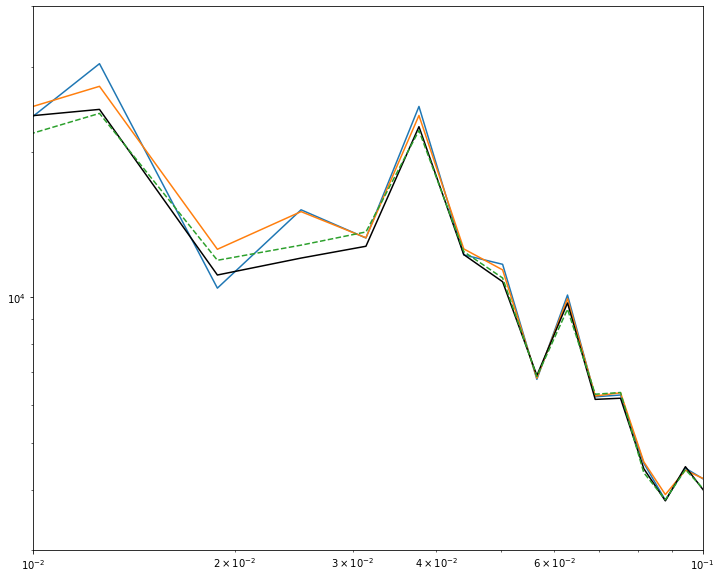

In [33]:
plt.figure(figsize=(12,10))
plt.plot(k_est,tests)
plt.plot(k_est,tests11)
plt.plot(k_est,tests1,'k')
plt.plot(k_est,tests2,'--')
plt.xlim(1e-2,1e-1)
plt.ylim(3e+3,4e4)
plt.yscale('log')
plt.xscale('log')

NameError: name 'tests1' is not defined

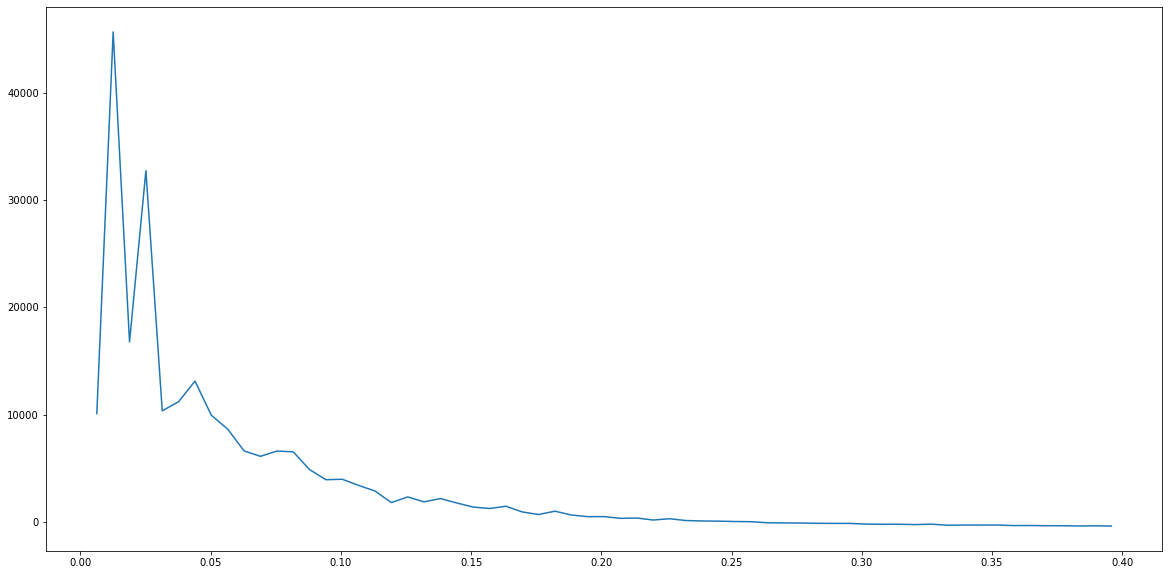

In [9]:
plt.figure(figsize=(20,10))
plt.plot(k_est,tests.real)
#class Pk_new:
    def __init__(self,delta,L,Nside,l,k,grid_info,binning_info,
                 t=0,ex_order=1,iFFT=False,dtype=np.complex128,threads=1,rfft=False,verbose=True):
        
        #unpack variables from grid info and binning info...
        xi,x_norm,ki,k_mag,MAS,k_f,k_ny = grid_info
        In_bin,N_modes = binning_info

        #raise warning if bad dtype
        if dtype != np.complex128 and dtype != np.complex64:
            raise Exception("Invalid dtype")
            
        N_side = len(delta)
        #import which fft type we want to use for the estimator
        #also sets some values in the case of real FFTs - i.e. fourier space arrays are halved
        if rfft:
            N_side_r = N_side//2 + 1                   #N_side changes in last axis for rffts
            if dtype == np.complex128:
                from FFTW import FFTW_irfft_double as iFFT_
                from FFTW import FFTW_rfft_double as FFT_       
                dtype_r = np.float64                            #dtype changes in real space for rffts
            elif dtype == np.complex64:
                from FFTW import FFTW_irfft_single as iFFT_
                from FFTW import FFTW_rfft_single as FFT_
                dtype_r = np.float32
        else:
            if dtype == np.complex128:
                from FFTW import FFTW_ifft_double as iFFT_
                from FFTW import FFTW_fft_double as FFT_         
            elif dtype == np.complex64:
                from FFTW import FFTW_ifft_single as iFFT_
                from FFTW import FFTW_fft_single as FFT_
            dtype_r = dtype                         
            N_side_r = N_side                       
        
        #initialize global variables
        #FFT_number=0;iFFT_number=0
        #wrapper function for FFT scheme imported from FFTW module - counts FFTs
        def FFTW_fft(delta):
            global FFT_number
            FFT_number += 1
            return FFT_(delta,threads)
        #wrapper function for iFFT scheme imported from FFTW module - counts iFFTs
        def FFTW_ifft(delta):
            global iFFT_number
            iFFT_number += 1
            return iFFT_(delta,threads)
        
                #Caluclate Q_ij etc and sums over to get G - without summing Qpqrs2 (i.e.  requires a lot more memory...
        #so this is for the q1.r1 parts
        def Qpqrs(delta,xi,ki,l): # extends
            if l == 0:
                return FFTW_fft(delta) # this is need for the way Pk_bisector is implemented

            kQ_sum = np.zeros((N_side,N_side,N_side_r)) # create empty array

            ind = np.array(list(combinations_with_replacement(np.arange(3), l))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            for i in ind: # so iterates for each possible ij etc

                k_prod = np.prod(ki[i],axis=0) # sum kx etc arrays for each combination
                x_prod = np.prod(xi[i],axis=0) #real parts
                #count distinct permutation for each combination
                kQ_sum = np.add(kQ_sum,np.multiply(bf.count_distinct_permutations(i)*k_prod,FFTW_fft(delta*x_prod),dtype=dtype)) # e.g. all terms in square brackets eq.20 scoccimarro

            return kQ_sum
        
        """
        #ok so need a function that for each multipole then computes different xi and ki
        #-t x1 (x1.x2)/x1
        def Fields_func(delta,k1,xi,x_norm,l): # extends
            F_1 = np.zeros((3,N_side,N_side,N_side_r),dtype=np.complex128) # create empty array
            F_2 = np.zeros((3,N_side,N_side,N_side_r),dtype=np.complex128) # create empty array
            #for the dot products if they to a power...
            ind = np.array(list(combinations_with_replacement(np.arange(3), l))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            
            for i in range(3): # so iterates for each possible ij etc # this for x1.x2 part
                x_prod12 = xi[i]#np.prod(x2[i],axis=0) #so this second dot product
                #bf.count_distinct_permutations(i)*
                F_2[i] = FFTW_fft(delta*x_prod12) # e.g. all terms in square brackets eq.20 scoccimarro
                for j in ind: #for k1.x1 part
                    k_prod = np.prod(k1[j],axis=0) # sum kx etc arrays for each combination
                    x_prod = np.prod(xi[j]/x_norm,axis=0) #real parts
                    
                    #count distinct permutation for each combination
                    F_1[i] += bf.count_distinct_permutations(j)*k_prod*FFTW_fft(delta*x_prod*x_prod12/x_norm**2) # e.g. all terms in square brackets eq.20 scoccimarro
                    
            return F_1,F_2"""
        
        # (k1.x_{field})^l1 (x1.x2)^l2
        def Fields_func(delta,k1,xi,x_norm,l1,l2,field=1):
            #for the two cartesian expansions
            ind1 = np.array(list(combinations_with_replacement(np.arange(3), l1))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            ind2 = np.array(list(combinations_with_replacement(np.arange(3), l2))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
   
            F_1 = np.zeros((len(ind2),N_side,N_side,N_side_r),dtype=np.complex128) # create empty array
            F_2 = np.zeros((len(ind2),N_side,N_side,N_side_r),dtype=np.complex128) # create empty array

            delta1 = delta*1  #assign fields
            delta2 = delta*1
            if field == 2:
                delta2 *= 1/(x_norm**(l1+2*l2))
            else:
                delta1 *= 1/(x_norm**(l1+2*l2))
            
            # so iterates for each possible ij etc   
            for i in range(len(ind2)):  # this for x1.x2 part
                x_prod2 = np.prod(xi[ind2[i]],axis=0)
                F_2[i] = bf.count_distinct_permutations(ind2[i])*FFTW_fft(delta2*x_prod2) # e.g. all terms in square brackets eq.20 scoccimarro
                for j in ind1: #for k1.x1 part #this is then condensed...
                    k_prod = np.prod(k1[j],axis=0) # sum kx etc arrays for each combination
                    x_prod = np.prod(xi[j],axis=0) #sum xi etc
                    F_1[i] += bf.count_distinct_permutations(j)*k_prod*FFTW_fft(delta1*x_prod*x_prod2) # e.g. all terms in square brackets eq.20 scoccimarro
                    
            return F_1,F_2
        
        
        # (k1.x_2)^l1 (k1.x_1)^l1 (x1.x2)^l2 # this for one term in second order quadrupole expansion
        def Fields_func2(delta,k1,xi,x_norm,l1,l2):
            #for the two cartesian expansions
            ind1 = np.array(list(combinations_with_replacement(np.arange(3), l1))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            ind2 = np.array(list(combinations_with_replacement(np.arange(3), l2))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
   
            F_1 = np.zeros((len(ind2),N_side,N_side,N_side_r),dtype=np.complex128) # create empty array
            F_2 = np.zeros((len(ind2),N_side,N_side,N_side_r),dtype=np.complex128) # create empty array

            delta1 = delta/(x_norm**(2*l1+2*l2))  #assign fields
            
            # so iterates for each possible ij etc   
            for i in range(len(ind2)):  # this for x1.x2 part
                x_prod2 = np.prod(xi[ind2[i]],axis=0)
                for j in ind1: #for k1.x1 and k1.x2 part
                    k_prod = np.prod(k1[j],axis=0) # sum kx etc arrays for each combination
                    x_prod = np.prod(xi[j],axis=0) #sum xi etc
                    perms1 = bf.count_distinct_permutations(j)
                    perms2 = bf.count_distinct_permutations(ind2[i])
                    F_1[i] += perms1*k_prod*FFTW_fft(delta1*x_prod*x_prod2) 
                    F_2[i] += perms1*perms2*k_prod*FFTW_fft(delta*x_prod*x_prod2) 
                    
            return F_1,F_2
        
        #ok so need a function that for each multipole then computes different xi and ki
        def Qpqrs(delta,xi,ki,l): # extends
            if l == 0:
                return FFTW_fft(delta) # this is need for the way Pk_bisector is implemented

            kQ_sum = np.zeros((N_side,N_side,N_side_r)) # create empty array

            ind = np.array(list(combinations_with_replacement(np.arange(3), l))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            for i in ind: # so iterates for each possible ij etc

                k_prod = np.prod(ki[i],axis=0) # sum kx etc arrays for each combination
                x_prod = np.prod(xi[i],axis=0) #real parts
                #count distinct permutation for each combination
                kQ_sum = np.add(kQ_sum,np.multiply(bf.count_distinct_permutations(i)*k_prod,FFTW_fft(delta*x_prod),dtype=dtype)) # e.g. all terms in square brackets eq.20 scoccimarro

            return kQ_sum
        
        
        #calculates Pk using a direct estimator method - midpoint so just doesn't use iFFTs
        def Pk_main(delta,k_,l):
            global FFT_number
            FFT_number = 0

            Npix = Nside**3
            V = L**3
            H = V/Npix
            const = (H**2)/V
            
            Nbins = len(k_)
            def main_func(l):
                Pk_lm = np.zeros(Nbins,dtype=dtype)
                if l == 0:
                    return Pk_mono

                if l==1:
                    #get the two fields Q_m and Q_n etc - for second field k2 = -k1 which we are expanding around    
                    F_1 = Qpqrs(delta/x_norm,xi,ki,1)*MAS
                    F_2 = FFTW_fft(delta)*MAS  #(-1)**(f123[1]) is there as we have negative k for second field

                    power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                    #power_bin = np.sum(power_k[np.newaxis, ...] * In_bin, axis=(1,2,3))
                    for j in range(len(k_)):
                        power_bin = np.sum(power_k[In_bin[j]])
                        Pk_lm[j] += const*power_bin/N_modes[j]
                    
                    
                    if t > 0:
                        if ex_order ==1:
                            #t k.x2/x1
                            F_1 = FFTW_fft(delta/x_norm)*MAS#Qpqrs(delta,norm,ki,1)
                            F_2 = Qpqrs(delta,xi,ki,1)*MAS#so this has the k term...
                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            #power_bin = np.sum(power_k[np.newaxis, ...] * In_bin, axis=(1,2,3))
                            for j in range(len(k_)):
                                power_bin = t*np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += const*power_bin/N_modes[j]

                            #ok so -t(k1.x1)(x1.x2) #so there are 9 terms -(first 3 are collasped down)...
                            F_1,F_2 = Fields_func(delta,ki,xi,x_norm,1,1)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))  #power_bin = np.sum(power_k[np.newaxis, ...] * In_bin, axis=(1,2,3))
                            for i in range(3):
                                for j in range(len(k_)):
                                    power_bin = -t*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]

                        else:
                            #lets go to second order...
                            #only thing that changes for 1st few terms is (t**2+t)
                            #(t^2+t) k.x2/x1
                            F_1 = FFTW_fft(delta/x_norm)*MAS#Qpqrs(delta,norm,ki,1)
                            F_2 = Qpqrs(delta,xi,ki,1)*MAS#so this has the k term...
                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            for j in range(len(k_)):
                                power_bin = (t**2+t)*np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += const*power_bin/N_modes[j]
                                
                            #ok so -(t^2+t)(k1.x1)(x1.x2) #so there are 9 terms -(first 3 are collasped down)...
                            F_1,F_2 = Fields_func(delta,ki,xi,x_norm,1,1)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))
                            for i in range(3):
                                for j in range(len(k_)):
                                    power_bin = -(t**2+t)*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]
                            
                            #-(t^2)(k1.x2)(x1.x2)
                            F_2,F_1 = Fields_func(delta,ki,xi,x_norm,1,1,2) # when field =2 then F_2 and F_1 switch
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))
                            for i in range(3):
                                for j in range(len(k_)):
                                    power_bin = -(t**2)*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]
                                    
                            #3/2 (t^2)(k1.x1)(x1.x2)^2
                            F_1,F_2 = Fields_func(delta,ki,xi,x_norm,1,2)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (6,(field))
                            for i in range(6):
                                for j in range(len(k_)):
                                    power_bin = (3/2)*(t**2)*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]
                                            
                            #-1/2 (t^2)(k1.x1)(x2.x2)
                            F_1 = Qpqrs(delta,xi/x_norm**3,ki,1)*MAS#so this has the k term...
                            F_2 = FFTW_fft(delta*x_norm**2)*MAS
                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            for j in range(len(k_)):
                                power_bin = -(1/2)*(t**2)*np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += const*power_bin/N_modes[j]
                                          
                if l==2:
                    #get the two fields Q_m and Q_n etc - for second field k2 = -k1 which we are expanding around    
                    F_1 = Qpqrs(delta/(x_norm**2),xi,ki,2)*MAS
                    F_2 = FFTW_fft(delta)*MAS  #(-1)**(f123[1]) is there as we have negative k for second field
                    power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                    for j in range(len(k_)):
                        power_bin = np.sum(power_k[In_bin[j]])
                        Pk_lm[j] += const*power_bin/N_modes[j]
                        
                    if t > 0:
                        if ex_order ==1:
                            #2t (k.x1)(k.x2)/x1
                            F_1 = Qpqrs(delta/(x_norm**2),xi,ki,1)*MAS
                            F_2 = Qpqrs(delta,xi,ki,1)*MAS
                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            for j in range(len(k_)):
                                power_bin = 2*t*np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += const*power_bin/N_modes[j]

                            #-2t(k.x1)^2 (x1.x2)/x2
                            F_1,F_2 = Fields_func(delta,ki,xi,x_norm,2,1)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))  #power_bin = np.sum(power_k[np.newaxis, ...] * In_bin, axis=(1,2,3))
                            for i in range(3):
                                for j in range(len(k_)):
                                    power_bin = -2*t*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]
                                    
                        elif ex_order == 2:
                            
                            #lets go to second order...
                            #2(t^2+t) (k.x1)(k.x2)/x1
                            F_1 = Qpqrs(delta/x_norm**2,xi,ki,1)*MAS
                            F_2 = Qpqrs(delta,xi,ki,1)*MAS
                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            for j in range(len(k_)):
                                power_bin = 2*(t**2+t)*np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += const*power_bin/N_modes[j]

                            #-2(t^2+t)(k.x1)^2 (x1.x2)/x2
                            F_1,F_2 = Fields_func(delta,ki,xi,x_norm,2,1)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))
                            for i in range(3):
                                for j in range(len(k_)):
                                    power_bin = -2*(t**2+t)*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]

                            #t^2 (k.x2)^2
                            F_1 = FFTW_fft(delta/x_norm**2)*MAS  
                            F_2 = Qpqrs(delta,xi,ki,2)*MAS
                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            for j in range(len(k_)):
                                power_bin = t**2 *np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += const*power_bin/N_modes[j]

                            #-4 t^2 (k.x1)(k.x2)(x1.x2)    
                            F_1,F_2 = Fields_func2(delta,ki,xi,x_norm,1,1)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))  #power_bin = np.sum(power_k[np.newaxis, ...] * In_bin, axis=(1,2,3))
                            for i in range(3):
                                for j in range(len(k_)):
                                    power_bin = -4*(t**2)*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]

                            #4 (t^2) (k.x1)^2 (x1.x2)^2
                            l1=2;l2=2
                            F_1,F_2 = Fields_func(delta,ki,xi,x_norm,l1,l2)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))  
                            for i in range(int((l2+1)*(l2+2)/2)):
                                for j in range(len(k_)):
                                    power_bin = 4*(t**2)*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]

                            #-(t^2)(k1.x1)^2 (x2.x2)
                            F_1 = Qpqrs(delta/x_norm**4,xi,ki,2)*MAS#so this has the k term...
                            F_2 = FFTW_fft(delta*x_norm**2)*MAS
                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            for j in range(len(k_)):
                                power_bin = -(t**2)*np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += const*power_bin/N_modes[j]
                          
                return Pk_lm

            def Pk_legendre(l):
                if l == 0:
                    return main_func(0)
                if l == 1:
                    return main_func(1)
                if l == 2:
                    return (1/2)*(3*main_func(2)-main_func(0))
                if l == 3:
                    return (1/2)*(5*main_func(3)- 3*main_func(1))
                if l == 4:
                    return (1/8)*(35*main_func(4)- 30*main_func(2) + 3*main_func(0))
                else:
                    raise "Multipole not implemented"
            
            Pk_lm = Pk_legendre(l)
            return (2*l+1)*(Pk_lm)
        
        #calculates Pk using a direct estimator method - endpoint version
        def Pk_endpoint(delta,k,l):
            global FFT_number
            FFT_number = 0
            
            #Lengendre multipoles
            def delta_lm(delta_x,delta_k,xi,ki,l):  #convolves delta with legendre polynomial
                if l == 0:
                    return delta_k
                if l==1:
                    Q_x = Qpqrs(delta_x,xi,ki,l)
                    return Q_x
                if l==2:
                    Q_xx = Qpqrs(delta_x,xi,ki,l)
                    return (3/2)*Q_xx - (1/2)*delta_k
                if l==3:
                    Q_xx = Qpqrs(delta_x,xi,ki,l)
                    return (1/2)*(5*Q_xx - 3*delta_lm(delta_x,delta_k,xi,ki,1))
                if l==4:
                    Q_xxxx = Qpqrs(delta_x,xi,ki,l)
                    return (35/8)*Q_xxxx - (5/2)*delta_lm(delta_x,delta_k,xi,ki,2) - (7/8)*delta_k
                else:
                    raise Exception(l,"l-multipole not implemented")
                    
            delta_k = FFTW_fft(delta)
                    
                    
            #calculate convolved field.
            delta_l = delta_lm(delta,delta_k,xi,ki,l)*MAS #this is the delta_l #plane_parallel
            delta_kk = delta_k*MAS

            Npix = Nside**3
            V = L**3
            H = V/Npix
            const = (H**2)/V

            Pk = np.zeros(len(k),dtype=dtype)
            power_k = delta_l*np.conj(delta_kk)#has to be conjugate as this creates the other part from from rfft - so if you consider full fft then we get double N_modes and Power_bin which cancels
            for i in range(len(k)):
                power_bin = np.sum(power_k[In_bin[i]])
                Pk[i] = const*power_bin/N_modes[i]
            return (2*l+1)*Pk
        
        Pk_mono = Pk_endpoint(delta,k,0)
        self.mono = Pk_mono

        self.pk = Pk_main(delta,k,l)plt.plot(k_est,tests1.real)
#class Pk_new:
    def __init__(self,delta,L,Nside,l,k,grid_info,binning_info,
                 t=0,ex_order=1,iFFT=False,dtype=np.complex128,threads=1,rfft=False,verbose=True):
        
        #unpack variables from grid info and binning info...
        xi,x_norm,ki,k_mag,MAS,k_f,k_ny = grid_info
        In_bin,N_modes = binning_info

        #raise warning if bad dtype
        if dtype != np.complex128 and dtype != np.complex64:
            raise Exception("Invalid dtype")
            
        N_side = len(delta)
        #import which fft type we want to use for the estimator
        #also sets some values in the case of real FFTs - i.e. fourier space arrays are halved
        if rfft:
            N_side_r = N_side//2 + 1                   #N_side changes in last axis for rffts
            if dtype == np.complex128:
                from FFTW import FFTW_irfft_double as iFFT_
                from FFTW import FFTW_rfft_double as FFT_       
                dtype_r = np.float64                            #dtype changes in real space for rffts
            elif dtype == np.complex64:
                from FFTW import FFTW_irfft_single as iFFT_
                from FFTW import FFTW_rfft_single as FFT_
                dtype_r = np.float32
        else:
            if dtype == np.complex128:
                from FFTW import FFTW_ifft_double as iFFT_
                from FFTW import FFTW_fft_double as FFT_         
            elif dtype == np.complex64:
                from FFTW import FFTW_ifft_single as iFFT_
                from FFTW import FFTW_fft_single as FFT_
            dtype_r = dtype                         
            N_side_r = N_side                       
        
        #initialize global variables
        #FFT_number=0;iFFT_number=0
        #wrapper function for FFT scheme imported from FFTW module - counts FFTs
        def FFTW_fft(delta):
            global FFT_number
            FFT_number += 1
            return FFT_(delta,threads)
        #wrapper function for iFFT scheme imported from FFTW module - counts iFFTs
        def FFTW_ifft(delta):
            global iFFT_number
            iFFT_number += 1
            return iFFT_(delta,threads)
        
                #Caluclate Q_ij etc and sums over to get G - without summing Qpqrs2 (i.e.  requires a lot more memory...
        #so this is for the q1.r1 parts
        def Qpqrs(delta,xi,ki,l): # extends
            if l == 0:
                return FFTW_fft(delta) # this is need for the way Pk_bisector is implemented

            kQ_sum = np.zeros((N_side,N_side,N_side_r)) # create empty array

            ind = np.array(list(combinations_with_replacement(np.arange(3), l))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            for i in ind: # so iterates for each possible ij etc

                k_prod = np.prod(ki[i],axis=0) # sum kx etc arrays for each combination
                x_prod = np.prod(xi[i],axis=0) #real parts
                #count distinct permutation for each combination
                kQ_sum = np.add(kQ_sum,np.multiply(bf.count_distinct_permutations(i)*k_prod,FFTW_fft(delta*x_prod),dtype=dtype)) # e.g. all terms in square brackets eq.20 scoccimarro

            return kQ_sum
        
        """
        #ok so need a function that for each multipole then computes different xi and ki
        #-t x1 (x1.x2)/x1
        def Fields_func(delta,k1,xi,x_norm,l): # extends
            F_1 = np.zeros((3,N_side,N_side,N_side_r),dtype=np.complex128) # create empty array
            F_2 = np.zeros((3,N_side,N_side,N_side_r),dtype=np.complex128) # create empty array
            #for the dot products if they to a power...
            ind = np.array(list(combinations_with_replacement(np.arange(3), l))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            
            for i in range(3): # so iterates for each possible ij etc # this for x1.x2 part
                x_prod12 = xi[i]#np.prod(x2[i],axis=0) #so this second dot product
                #bf.count_distinct_permutations(i)*
                F_2[i] = FFTW_fft(delta*x_prod12) # e.g. all terms in square brackets eq.20 scoccimarro
                for j in ind: #for k1.x1 part
                    k_prod = np.prod(k1[j],axis=0) # sum kx etc arrays for each combination
                    x_prod = np.prod(xi[j]/x_norm,axis=0) #real parts
                    
                    #count distinct permutation for each combination
                    F_1[i] += bf.count_distinct_permutations(j)*k_prod*FFTW_fft(delta*x_prod*x_prod12/x_norm**2) # e.g. all terms in square brackets eq.20 scoccimarro
                    
            return F_1,F_2"""
        
        # (k1.x_{field})^l1 (x1.x2)^l2
        def Fields_func(delta,k1,xi,x_norm,l1,l2,field=1):
            #for the two cartesian expansions
            ind1 = np.array(list(combinations_with_replacement(np.arange(3), l1))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            ind2 = np.array(list(combinations_with_replacement(np.arange(3), l2))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
   
            F_1 = np.zeros((len(ind2),N_side,N_side,N_side_r),dtype=np.complex128) # create empty array
            F_2 = np.zeros((len(ind2),N_side,N_side,N_side_r),dtype=np.complex128) # create empty array

            delta1 = delta*1  #assign fields
            delta2 = delta*1
            if field == 2:
                delta2 *= 1/(x_norm**(l1+2*l2))
            else:
                delta1 *= 1/(x_norm**(l1+2*l2))
            
            # so iterates for each possible ij etc   
            for i in range(len(ind2)):  # this for x1.x2 part
                x_prod2 = np.prod(xi[ind2[i]],axis=0)
                F_2[i] = bf.count_distinct_permutations(ind2[i])*FFTW_fft(delta2*x_prod2) # e.g. all terms in square brackets eq.20 scoccimarro
                for j in ind1: #for k1.x1 part #this is then condensed...
                    k_prod = np.prod(k1[j],axis=0) # sum kx etc arrays for each combination
                    x_prod = np.prod(xi[j],axis=0) #sum xi etc
                    F_1[i] += bf.count_distinct_permutations(j)*k_prod*FFTW_fft(delta1*x_prod*x_prod2) # e.g. all terms in square brackets eq.20 scoccimarro
                    
            return F_1,F_2
        
        
        # (k1.x_2)^l1 (k1.x_1)^l1 (x1.x2)^l2 # this for one term in second order quadrupole expansion
        def Fields_func2(delta,k1,xi,x_norm,l1,l2):
            #for the two cartesian expansions
            ind1 = np.array(list(combinations_with_replacement(np.arange(3), l1))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            ind2 = np.array(list(combinations_with_replacement(np.arange(3), l2))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
   
            F_1 = np.zeros((len(ind2),N_side,N_side,N_side_r),dtype=np.complex128) # create empty array
            F_2 = np.zeros((len(ind2),N_side,N_side,N_side_r),dtype=np.complex128) # create empty array

            delta1 = delta/(x_norm**(2*l1+2*l2))  #assign fields
            
            # so iterates for each possible ij etc   
            for i in range(len(ind2)):  # this for x1.x2 part
                x_prod2 = np.prod(xi[ind2[i]],axis=0)
                for j in ind1: #for k1.x1 and k1.x2 part
                    k_prod = np.prod(k1[j],axis=0) # sum kx etc arrays for each combination
                    x_prod = np.prod(xi[j],axis=0) #sum xi etc
                    perms1 = bf.count_distinct_permutations(j)
                    perms2 = bf.count_distinct_permutations(ind2[i])
                    F_1[i] += perms1*k_prod*FFTW_fft(delta1*x_prod*x_prod2) 
                    F_2[i] += perms1*perms2*k_prod*FFTW_fft(delta*x_prod*x_prod2) 
                    
            return F_1,F_2
        
        #ok so need a function that for each multipole then computes different xi and ki
        def Qpqrs(delta,xi,ki,l): # extends
            if l == 0:
                return FFTW_fft(delta) # this is need for the way Pk_bisector is implemented

            kQ_sum = np.zeros((N_side,N_side,N_side_r)) # create empty array

            ind = np.array(list(combinations_with_replacement(np.arange(3), l))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            for i in ind: # so iterates for each possible ij etc

                k_prod = np.prod(ki[i],axis=0) # sum kx etc arrays for each combination
                x_prod = np.prod(xi[i],axis=0) #real parts
                #count distinct permutation for each combination
                kQ_sum = np.add(kQ_sum,np.multiply(bf.count_distinct_permutations(i)*k_prod,FFTW_fft(delta*x_prod),dtype=dtype)) # e.g. all terms in square brackets eq.20 scoccimarro

            return kQ_sum
        
        
        #calculates Pk using a direct estimator method - midpoint so just doesn't use iFFTs
        def Pk_main(delta,k_,l):
            global FFT_number
            FFT_number = 0

            Npix = Nside**3
            V = L**3
            H = V/Npix
            const = (H**2)/V
            
            Nbins = len(k_)
            def main_func(l):
                Pk_lm = np.zeros(Nbins,dtype=dtype)
                if l == 0:
                    return Pk_mono

                if l==1:
                    #get the two fields Q_m and Q_n etc - for second field k2 = -k1 which we are expanding around    
                    F_1 = Qpqrs(delta/x_norm,xi,ki,1)*MAS
                    F_2 = FFTW_fft(delta)*MAS  #(-1)**(f123[1]) is there as we have negative k for second field

                    power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                    #power_bin = np.sum(power_k[np.newaxis, ...] * In_bin, axis=(1,2,3))
                    for j in range(len(k_)):
                        power_bin = np.sum(power_k[In_bin[j]])
                        Pk_lm[j] += const*power_bin/N_modes[j]
                    
                    
                    if t > 0:
                        if ex_order ==1:
                            #t k.x2/x1
                            F_1 = FFTW_fft(delta/x_norm)*MAS#Qpqrs(delta,norm,ki,1)
                            F_2 = Qpqrs(delta,xi,ki,1)*MAS#so this has the k term...
                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            #power_bin = np.sum(power_k[np.newaxis, ...] * In_bin, axis=(1,2,3))
                            for j in range(len(k_)):
                                power_bin = t*np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += const*power_bin/N_modes[j]

                            #ok so -t(k1.x1)(x1.x2) #so there are 9 terms -(first 3 are collasped down)...
                            F_1,F_2 = Fields_func(delta,ki,xi,x_norm,1,1)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))  #power_bin = np.sum(power_k[np.newaxis, ...] * In_bin, axis=(1,2,3))
                            for i in range(3):
                                for j in range(len(k_)):
                                    power_bin = -t*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]

                        else:
                            #lets go to second order...
                            #only thing that changes for 1st few terms is (t**2+t)
                            #(t^2+t) k.x2/x1
                            F_1 = FFTW_fft(delta/x_norm)*MAS#Qpqrs(delta,norm,ki,1)
                            F_2 = Qpqrs(delta,xi,ki,1)*MAS#so this has the k term...
                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            for j in range(len(k_)):
                                power_bin = (t**2+t)*np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += const*power_bin/N_modes[j]
                                
                            #ok so -(t^2+t)(k1.x1)(x1.x2) #so there are 9 terms -(first 3 are collasped down)...
                            F_1,F_2 = Fields_func(delta,ki,xi,x_norm,1,1)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))
                            for i in range(3):
                                for j in range(len(k_)):
                                    power_bin = -(t**2+t)*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]
                            
                            #-(t^2)(k1.x2)(x1.x2)
                            F_2,F_1 = Fields_func(delta,ki,xi,x_norm,1,1,2) # when field =2 then F_2 and F_1 switch
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))
                            for i in range(3):
                                for j in range(len(k_)):
                                    power_bin = -(t**2)*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]
                                    
                            #3/2 (t^2)(k1.x1)(x1.x2)^2
                            F_1,F_2 = Fields_func(delta,ki,xi,x_norm,1,2)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (6,(field))
                            for i in range(6):
                                for j in range(len(k_)):
                                    power_bin = (3/2)*(t**2)*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]
                                            
                            #-1/2 (t^2)(k1.x1)(x2.x2)
                            F_1 = Qpqrs(delta,xi/x_norm**3,ki,1)*MAS#so this has the k term...
                            F_2 = FFTW_fft(delta*x_norm**2)*MAS
                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            for j in range(len(k_)):
                                power_bin = -(1/2)*(t**2)*np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += const*power_bin/N_modes[j]
                                          
                if l==2:
                    #get the two fields Q_m and Q_n etc - for second field k2 = -k1 which we are expanding around    
                    F_1 = Qpqrs(delta/(x_norm**2),xi,ki,2)*MAS
                    F_2 = FFTW_fft(delta)*MAS  #(-1)**(f123[1]) is there as we have negative k for second field
                    power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                    for j in range(len(k_)):
                        power_bin = np.sum(power_k[In_bin[j]])
                        Pk_lm[j] += const*power_bin/N_modes[j]
                        
                    if t > 0:
                        if ex_order ==1:
                            #2t (k.x1)(k.x2)/x1
                            F_1 = Qpqrs(delta/(x_norm**2),xi,ki,1)*MAS
                            F_2 = Qpqrs(delta,xi,ki,1)*MAS
                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            for j in range(len(k_)):
                                power_bin = 2*t*np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += const*power_bin/N_modes[j]

                            #-2t(k.x1)^2 (x1.x2)/x2
                            F_1,F_2 = Fields_func(delta,ki,xi,x_norm,2,1)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))  #power_bin = np.sum(power_k[np.newaxis, ...] * In_bin, axis=(1,2,3))
                            for i in range(3):
                                for j in range(len(k_)):
                                    power_bin = -2*t*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]
                                    
                        elif ex_order == 2:
                            
                            #lets go to second order...
                            #2(t^2+t) (k.x1)(k.x2)/x1
                            F_1 = Qpqrs(delta/x_norm**2,xi,ki,1)*MAS
                            F_2 = Qpqrs(delta,xi,ki,1)*MAS
                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            for j in range(len(k_)):
                                power_bin = 2*(t**2+t)*np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += const*power_bin/N_modes[j]

                            #-2(t^2+t)(k.x1)^2 (x1.x2)/x2
                            F_1,F_2 = Fields_func(delta,ki,xi,x_norm,2,1)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))
                            for i in range(3):
                                for j in range(len(k_)):
                                    power_bin = -2*(t**2+t)*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]

                            #t^2 (k.x2)^2
                            F_1 = FFTW_fft(delta/x_norm**2)*MAS  
                            F_2 = Qpqrs(delta,xi,ki,2)*MAS
                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            for j in range(len(k_)):
                                power_bin = t**2 *np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += const*power_bin/N_modes[j]

                            #-4 t^2 (k.x1)(k.x2)(x1.x2)    
                            F_1,F_2 = Fields_func2(delta,ki,xi,x_norm,1,1)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))  #power_bin = np.sum(power_k[np.newaxis, ...] * In_bin, axis=(1,2,3))
                            for i in range(3):
                                for j in range(len(k_)):
                                    power_bin = -4*(t**2)*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]

                            #4 (t^2) (k.x1)^2 (x1.x2)^2
                            l1=2;l2=2
                            F_1,F_2 = Fields_func(delta,ki,xi,x_norm,l1,l2)
                            power_k = F_1*MAS*np.conj(F_2*MAS)#is conjugate as F(-k) = F*(k)
                            #ok F_1 and F_2 have shape (3,(field))  
                            for i in range(int((l2+1)*(l2+2)/2)):
                                for j in range(len(k_)):
                                    power_bin = 4*(t**2)*np.sum(power_k[i][In_bin[j]])
                                    Pk_lm[j] += const*power_bin/N_modes[j]

                            #-(t^2)(k1.x1)^2 (x2.x2)
                            F_1 = Qpqrs(delta/x_norm**4,xi,ki,2)*MAS#so this has the k term...
                            F_2 = FFTW_fft(delta*x_norm**2)*MAS
                            power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                            for j in range(len(k_)):
                                power_bin = -(t**2)*np.sum(power_k[In_bin[j]])
                                Pk_lm[j] += const*power_bin/N_modes[j]
                          
                return Pk_lm

            def Pk_legendre(l):
                if l == 0:
                    return main_func(0)
                if l == 1:
                    return main_func(1)
                if l == 2:
                    return (1/2)*(3*main_func(2)-main_func(0))
                if l == 3:
                    return (1/2)*(5*main_func(3)- 3*main_func(1))
                if l == 4:
                    return (1/8)*(35*main_func(4)- 30*main_func(2) + 3*main_func(0))
                else:
                    raise "Multipole not implemented"
            
            Pk_lm = Pk_legendre(l)
            return (2*l+1)*(Pk_lm)
        
        #calculates Pk using a direct estimator method - endpoint version
        def Pk_endpoint(delta,k,l):
            global FFT_number
            FFT_number = 0
            
            #Lengendre multipoles
            def delta_lm(delta_x,delta_k,xi,ki,l):  #convolves delta with legendre polynomial
                if l == 0:
                    return delta_k
                if l==1:
                    Q_x = Qpqrs(delta_x,xi,ki,l)
                    return Q_x
                if l==2:
                    Q_xx = Qpqrs(delta_x,xi,ki,l)
                    return (3/2)*Q_xx - (1/2)*delta_k
                if l==3:
                    Q_xx = Qpqrs(delta_x,xi,ki,l)
                    return (1/2)*(5*Q_xx - 3*delta_lm(delta_x,delta_k,xi,ki,1))
                if l==4:
                    Q_xxxx = Qpqrs(delta_x,xi,ki,l)
                    return (35/8)*Q_xxxx - (5/2)*delta_lm(delta_x,delta_k,xi,ki,2) - (7/8)*delta_k
                else:
                    raise Exception(l,"l-multipole not implemented")
                    
            delta_k = FFTW_fft(delta)
                    
                    
            #calculate convolved field.
            delta_l = delta_lm(delta,delta_k,xi,ki,l)*MAS #this is the delta_l #plane_parallel
            delta_kk = delta_k*MAS

            Npix = Nside**3
            V = L**3
            H = V/Npix
            const = (H**2)/V

            Pk = np.zeros(len(k),dtype=dtype)
            power_k = delta_l*np.conj(delta_kk)#has to be conjugate as this creates the other part from from rfft - so if you consider full fft then we get double N_modes and Power_bin which cancels
            for i in range(len(k)):
                power_bin = np.sum(power_k[In_bin[i]])
                Pk[i] = const*power_bin/N_modes[i]
            return (2*l+1)*Pk
        
        Pk_mono = Pk_endpoint(delta,k,0)
        self.mono = Pk_mono

        self.pk = Pk_main(delta,k,l)plt.plot(k_est,tests2.real)


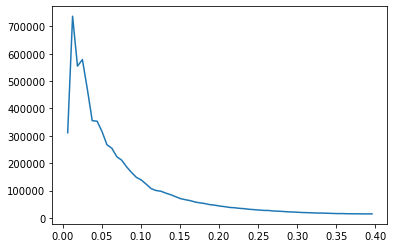

In [1006]:
plt.plot(k_est,-np.sum(tests.real,axis=0))

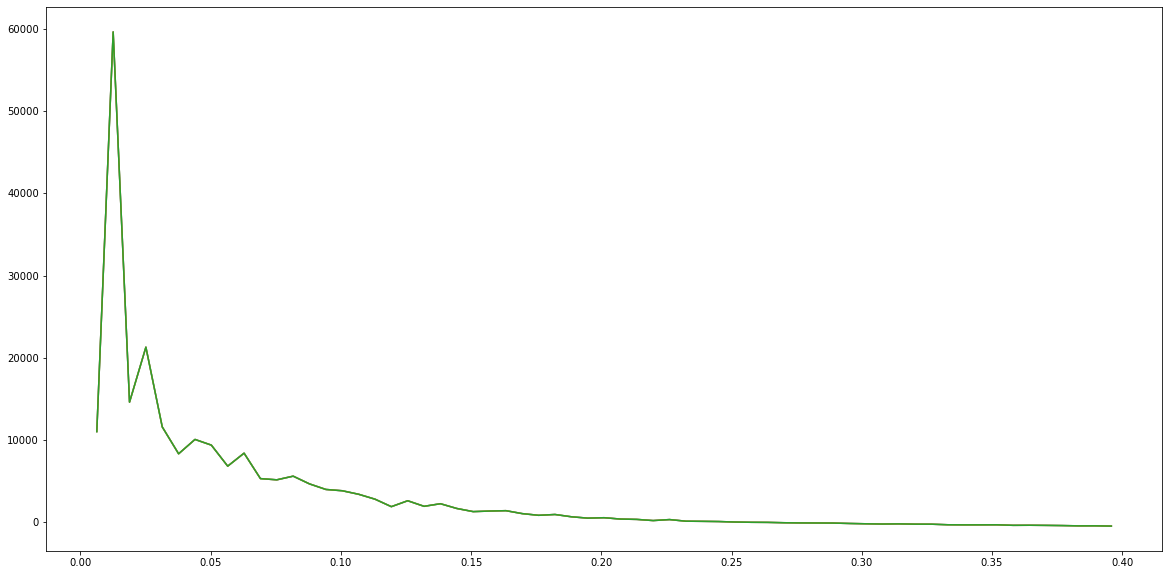

In [1022]:
plt.figure(figsize=(20,10))
plt.plot(k_est,tests[0].real)
plt.plot(k_est,tests1[0].real)
plt.plot(k_est,tests2[0].real)

In [722]:
#%%time
plt.figure(figsize=(20,10))
for i in range(10):
    realisation = str(10000 + i)
    l=1
    t=0.5
    field_tmp = np.load('../'+path + 'fields_CIC/' + realisation + '_' + red_info + '_' + str(N_side) + '_LOS=0'+ '.npy') #load field
    stuff = np.zeros((10,len(k_est)),dtype=np.complex128)
    stuff[i] = Pk_new(field_tmp,L,Nside,l,k_est,grid_info,binning_info,t,1,iFFT,dtype,threads,rfft,verbose).pk
    stuff2 = np.zeros((10,len(k_est)),dtype=np.complex128)
    stuff2[i] = Pk(field_tmp,L,Nside,l,k_est,grid_info,binning_info,0,iFFT,dtype,threads,rfft,verbose).pk

(63, 128, 128, 128)
(63, 128, 128, 128)
(63, 128, 128, 128)
(63, 128, 128, 128)
(63, 128, 128, 128)
(63, 128, 128, 128)
(63, 128, 128, 128)
(63, 128, 128, 128)
(63, 128, 128, 128)
(63, 128, 128, 128)


<Figure size 1440x720 with 0 Axes>

In [726]:
avg= np.mean(stuff,axis=0)
avg2= np.mean(stuff2,axis=0)


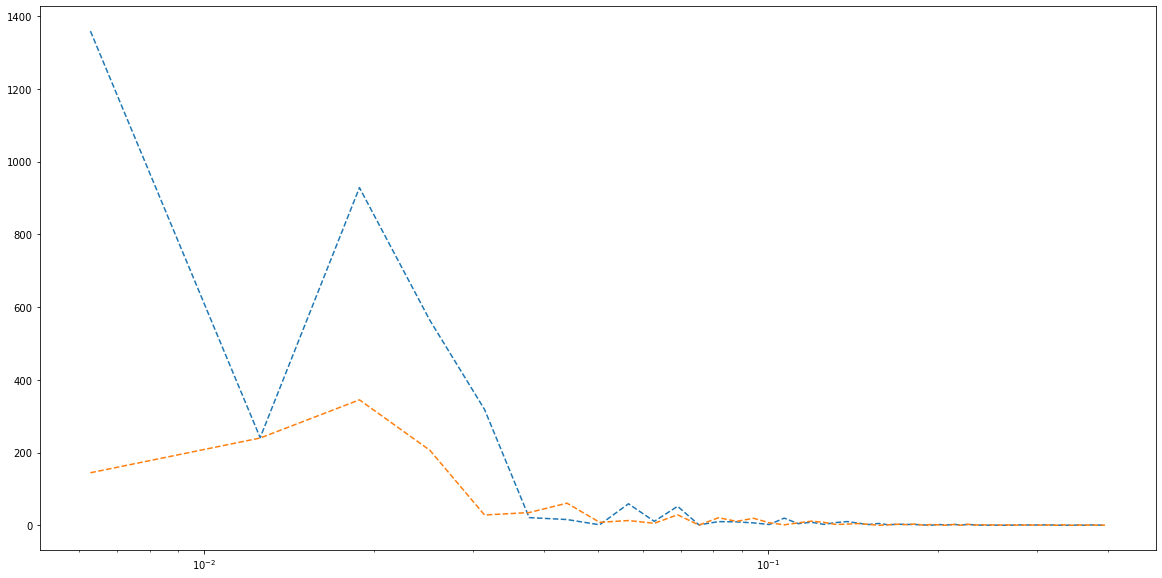

In [729]:

plt.figure(figsize=(20,10))
#plt.plot(k_est,np.abs(avg.imag),'-')

#plt.plot(k_est,(avg[1].imag))
#plt.plot(k_est,(avg[2].imag))
plt.plot(k_est,np.abs(avg2),'--')
plt.plot(k_est,np.abs(avg),'--')
#plt.yscale('log')
plt.xscale('log')

AttributeError: 'tuple' object has no attribute 'imag'

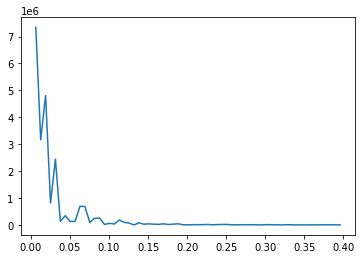

In [301]:
plt.plot(k_est,np.abs(tests.imag))
plt.plot(k_est,np.abs(tests_.imag))
#plt.plot(k_est,np.abs(tests1.real))

plt.yscale('log')
plt.xscale('log')
#plt.xlim(1e-2,2e-1)

In [93]:
#so for forced quadrupole with spherical harmonic decomposition


In [30]:
import sympy as sp
import scipy
from sympy import Ynm, Symbol, simplify

In [31]:
scipy.special.sph_harm(2, 1)

ValueError: invalid number of arguments

In [39]:
theta = Symbol("theta")
phi = Symbol("phi")
x = Symbol('x')
ddd = sympy.functions.special.spherical_harmonics.Ynm(2, 0, theta, phi)

In [41]:
a = simplify(ddd.expand(func=True)).subs([Cos(theta),x])

NameError: name 'Cos' is not defined

In [38]:
print(a)

sqrt(5)*(3*cos(theta)**2 - 1)/(4*sqrt(pi))


In [91]:
%%time
import sympy as sp
l = 2
m = 1
# define the symbols
x, y, z, r, theta, phi = sp.symbols('x y z r theta phi')
x1, x2, y1, y2, z1, z2 = sp.symbols('x1 x2 y1 y2 z1 z2')

# define the spherical harmonics function
Y_lm = sympy.functions.special.spherical_harmonics.Ynm(l, m, theta, phi)

# convert to Cartesian coordinates
Y_lm_cartesian = Y_lm.expand(func=True).subs([(theta, sp.acos(z/r)), 
                            (phi, sp.atan2(y, x))])

# remove the exponential term
Y_lm_cartesian = Y_lm_cartesian.subs(sp.exp(sp.I * m * phi), sp.cos(m * phi) + sp.I * sp.sin(m * phi))
# perform the decomposition
Y_lm_cartesian = Y_lm_cartesian.subs([(sp.sin(theta), sp.sqrt(x**2 + y**2)/r),
                                      (sp.cos(theta), z/r)])

# remove the exponential term
Y_lm_cartesian = Y_lm_cartesian.subs(sp.exp(sp.I * m * phi), sp.cos(m * phi) + sp.I * sp.sin(m * phi))

# simplify the result
Y_lm_cartesian = sp.simplify(Y_lm_cartesian.subs([(x,(1-t)*x1+t*x2),(y,(1-t)*y1+t*y2),(z,(1-t)*z1+t*z2)]))

# print the result
print(Y_lm_cartesian.expand(func=True))

# define the function to be numerically evaluated
f = sp.lambdify((x1,x2, y, z), Y_lm_cartesian, 'numpy')


-0.125*sqrt(30)*z1*sqrt(1 - 0.25*z1**2/r**2 - 0.5*z1*z2/r**2 - 0.25*z2**2/r**2)*exp(I*atan2(0.5*y1 + 0.5*y2, 0.5*x1 + 0.5*x2))/(sqrt(pi)*r) - 0.125*sqrt(30)*z2*sqrt(1 - 0.25*z1**2/r**2 - 0.5*z1*z2/r**2 - 0.25*z2**2/r**2)*exp(I*atan2(0.5*y1 + 0.5*y2, 0.5*x1 + 0.5*x2))/(sqrt(pi)*r)
CPU times: user 95.7 ms, sys: 3.98 ms, total: 99.6 ms
Wall time: 96.9 ms


In [92]:
simplify(Y_lm_cartesian.expand(func=True))

-0.125*sqrt(30)*sqrt(-(-r**2 + 0.25*z1**2 + 0.5*z1*z2 + 0.25*z2**2)/r**2)*(z1 + z2)*exp(I*atan2(0.5*y1 + 0.5*y2, 0.5*x1 + 0.5*x2))/(sqrt(pi)*r)

In [81]:
f(0.2, 1, 1)

TypeError: _lambdifygenerated() missing 1 required positional argument: 'z'

In [ ]:
def ylm_norm(l,m):
    normalisation = (-1)**(m)*np.sqrt(((2*l+1)/(4*np.pi))*(np.math.factorial(int(l-np.abs(m)))/np.math.factorial(int(l+np.abs(m)))))
    return normalisation

print(ylm_norm(4,0))

def ylm(k_mag,kx,ky,kz,l,m):
    k_z = np.where(k_mag>0,kz/k_mag,0)
    k_y = np.where(k_mag>0,ky/k_mag,0)
    k_x = np.where(k_mag>0,kx/k_mag,0)

    #norm = ylm_norm(l,m)
    if m>l:
        print("Error l>m")
    
    if l == 0:
        return ylm_norm(0,0)
    elif l == 1:
        if m == 1:
            return (1/2)*np.sqrt(2/(2*np.pi))*(k_x+k_y*1j)
        if m == 0:
            return (1/2)*np.sqrt(2/(np.pi))*k_z
        if m == -1:
            return -(1/2)*np.sqrt(2/(2*np.pi))*(k_x-k_y*1j)
    elif l == 2:
        if m == 2:
            return (1/4)*np.sqrt(15/(2*np.pi))*(k_x+k_y*1j)**2
        if m == 1:
            return (1/2)*np.sqrt(15/(2*np.pi))*(k_x+k_y*1j)*k_z
        if m == 0:
            return (1/4)*np.sqrt(5/(np.pi))*(3*k_z**2-1)
        if m == -1:
            return -(1/2)*np.sqrt(15/(2*np.pi))*(k_x-k_y*1j)*k_z
        if m == -2:
            return (1/4)*np.sqrt(15/(2*np.pi))*(k_x-k_y*1j)**2
    elif l == 3:
        if m == 3:
            return (1/8)*np.sqrt(35/(np.pi))*(k_x+k_y*1j)**3
        if m == 2:
            return (1/4)*np.sqrt(105/(2*np.pi))*(k_x+k_y*1j)**(2)*k_z
        if m == 1:
            return (1/8)*np.sqrt(21/(np.pi))*(k_x+k_y*1j)*(5*k_z**2-1)
        if m == 0:
            return (1/4)*np.sqrt(7/(np.pi))*(5*k_z**3-3*k_z)
        if m == -1:
            return -(1/8)*np.sqrt(21/(np.pi))*(k_x-k_y*1j)*(5*k_z**2-1)
        if m == -2:
            return (1/8)*np.sqrt(105/(2*np.pi))*(k_x-k_y*1j)**(2)*k_z
        if m == -3:
            return -(1/8)*np.sqrt(35/(np.pi))*(k_x-k_y*1j)**3
    elif l == 4:
        if m == -4:
            return (3/16)*np.sqrt(35/(2*np.pi))*(k_x-k_y*1j)**4
        if m == -3:
            return (3/8)*np.sqrt(35/(np.pi))(1/8)*np.sqrt(35/(np.pi))(1/8)*np.sqrt(35/(np.pi))*(k_x-k_y*1j)**3*k_z
        if m == -2:
            return (3/8)*np.sqrt(5/(2*np.pi))(1/8)*np.sqrt(35/(np.pi))*(k_x-k_y*1j)**2*(7*k_z**3-3*k_z)
        if m == -1:
            return (3/8)*np.sqrt(5/(np.pi))*(k_x-k_y*1j)*(7*k_z**3-3*k_z)
        if m == 0:
            return (3/16)*np.sqrt(1/(np.pi))*(35*k_z**4 - 30*k_z**2 + 3)
        if m == 1:
            return (-3/8)*np.sqrt(5/(np.pi))(1/8)*np.sqrt(35/(np.pi))(1/8)*np.sqrt(35/(np.pi))(1/8)*np.sqrt(35/(np.pi))*(k_x+k_y*1j)*(7*k_z**3-3*k_z)
        if m == 2:
            return (3/8)*np.sqrt(5/(5*np.pi))(1/8)*np.sqrt(35/(np.pi))(1/8)*np.sqrt(35/(np.pi))*(k_x+k_y*1j)**2*(7*k_z**3-3*k_z)
        if m == 3:
            return (-3/8)*np.sqrt(35/(np.pi))(1/8)*np.sqrt(35/(np.pi))*(k_x+k_y*1j)**3*k_z
        if m == -4:
            return (3/16)*np.sqrt(35/(2*np.pi))*(k_x+k_y*1j)**4
    else:
        print("l not in range!")
            
def delta_ylm(delta_k,k_mag,kx,ky,kz,l,m): 
    # so this will change when LoS is not (0,0,1) so that Qqprs and such will change
    return ylm(k_mag,kx,ky,kz,l,m)*delta_k

In [32]:
class Pk2:
    def __init__(self,delta,L,Nside,l,k,grid_info,binning_info,
                 t=0,iFFT=False,dtype=np.complex128,threads=1,rfft=False,verbose=True):
        
        #unpack variables from grid info and binning info...
        xi,ki,k_mag,MAS,k_f,k_ny = grid_info
        In_bin,N_modes = binning_info
        
        #raise warning if bad dtype
        if dtype != np.complex128 and dtype != np.complex64:
            raise Exception("Invalid dtype")
            
        N_side = len(delta)
        #import which fft type we want to use for the estimator
        #also sets some values in the case of real FFTs - i.e. fourier space arrays are halved
        if rfft:
            N_side_r = N_side//2 + 1                   #N_side changes in last axis for rffts
            if dtype == np.complex128:
                from FFTW import FFTW_irfft_double as iFFT_
                from FFTW import FFTW_rfft_double as FFT_       
                dtype_r = np.float64                            #dtype changes in real space for rffts
            elif dtype == np.complex64:
                from FFTW import FFTW_irfft_single as iFFT_
                from FFTW import FFTW_rfft_single as FFT_
                dtype_r = np.float32
        else:
            if dtype == np.complex128:
                from FFTW import FFTW_ifft_double as iFFT_
                from FFTW import FFTW_fft_double as FFT_         
            elif dtype == np.complex64:
                from FFTW import FFTW_ifft_single as iFFT_
                from FFTW import FFTW_fft_single as FFT_
            dtype_r = dtype                         
            N_side_r = N_side                       
        
        #initialize global variables
        #FFT_number=0;iFFT_number=0
        #wrapper function for FFT scheme imported from FFTW module - counts FFTs
        def FFTW_fft(delta):
            global FFT_number
            FFT_number += 1
            return FFT_(delta,threads)
        #wrapper function for iFFT scheme imported from FFTW module - counts iFFTs
        def FFTW_ifft(delta):
            global iFFT_number
            iFFT_number += 1
            return iFFT_(delta,threads)
        
                #Caluclate Q_ij etc and sums over to get G - without summing Qpqrs2 (i.e.  requires a lot more memory...
        #so this is for the q1.r1 parts
        def Qpqrs(delta,xi,ki,l): # extends
            if l == 0:
                return FFTW_fft(delta) # this is need for the way Pk_bisector is implemented

            kQ_sum = np.zeros((N_side,N_side,N_side_r)) # create empty array

            ind = np.array(list(combinations_with_replacement(np.arange(3), l))) #find all combinations for l components from x,y,z - (l+1)(l+2)/2 components
            for i in ind: # so iterates for each possible ij etc

                k_prod = np.prod(ki[i],axis=0) # sum kx etc arrays for each combination
                x_prod = np.prod(xi[i],axis=0) #real parts
                #count distinct permutation for each combination
                kQ_sum = np.add(kQ_sum,np.multiply(bf.count_distinct_permutations(i)*k_prod,FFTW_fft(delta*x_prod),dtype=dtype)) # e.g. all terms in square brackets eq.20 scoccimarro

            return kQ_sum

        #so this is the the same as above but allows for k1 . x2 example not just k1 . x1 - so fields are not summed over
        #so returns the k_i products as well the Q_ijs
        def Qpqrs2(delta,delta_k,xi,ki,l): # extends
            if l == 0:
                return delta_k # this is need for the way Pk is implemented
            N_side = int(len(delta[:,0,0]))  # this should just be calculated once
            kQ_sum = np.zeros((N_side,N_side,N_side_r)) # create empty array
            
            ind = np.array(list(combinations_with_replacement(np.arange(3), l))) #find all combinations for l components from x,y,z 
            kF = np.zeros((len(ind),N_side,N_side,N_side_r),dtype=dtype)
            H_ij = np.zeros((len(ind),N_side,N_side,N_side_r),dtype=dtype)
            for i in range(len(ind)): # so iterates for each possible ij etc
                k_prod = np.prod(ki[ind[i]],axis=0) # sum kx etc arrays for each combination
                x_prod = np.prod(xi[ind[i]],axis=0) #real parts
                #count distinct permutation for each combination
                kF[i] = bf.count_distinct_permutations(ind[i])*k_prod*delta_k #k1 terms
                H_ij[i] = FFTW_fft(delta*x_prod) #delta_k2,delta_k3 convolved x terms

            return kF,H_ij
                    
        
        #calculates Pk using a direct estimator method - midpoint so just doesn't use iFFTs
        def Pk_main(delta,k_,l):
            global FFT_number
            FFT_number = 0

            delta_k = FFTW_fft(delta) #no longer in get values
            Npix = Nside**3
            V = L**3
            H = V/Npix
            const = (H**2)/V

            Nbins = len(k_)
            #ok so like bispectrum but should have a lot fewer moving parts - go down from 3 to 2 
            def main_func(l):
                if l == 0:
                    return Pk_mono
                
                
                
                def delta_func(part):
                    
                    x_part = part # or z
                    g_delta = FFTW_fft(delta*x_part) #delta_k2,delta_k3 convolved x terms
                    return g_delta
                
                #m = 0
                totm0 = np.zeros((3,*delta.shape))
                totm0[0] = (1-t)**2 *delta(z**2)*delta(1)
                totm0[1]=t**2 *delta(z**2)*delta(1)
                totm0[2]=(1-t)*t*delta(z)*delta(z)
                
                #m=1
                totm1 = np.zeros((3,*delta.shape))
                totm1[0] = (1-t)**2 *delta(z*(x-y*1j))*delta(1)
                totm1[1]=t**2 *delta(z*(x-y*1j))*delta(1)
                totm1[2]=(1-t)*t*delta((x-y*1j))*delta(z) # there double of this??
                
                #m=2
                totm1 = np.zeros((3,*delta.shape))
                totm1[0] = (1-t)**2 *delta(z*(x-y*1j))*delta(1)
                totm1[1]=t**2 *delta(z*(x-y*1j))*delta(1)
                totm1[2]=(1-t)*t*delta((x-y*1j))*delta(z) # there double of this??
                
                
                
                
                
                
                
                
                ind = np.array(list(combinations_with_replacement(np.arange(2), l))) #find all combinations for l components from x,y,z
                Pk_lm = np.zeros(Nbins,dtype=dtype)
                #ok instead of doing that lets just save the A_{mn} etc 
                Amn = {}
                for i in range(0,len(ind)): # so iterates for each possible Amn etc   #proper stuff begins here
                    f123 = np.array([np.sum(ind[i]==0),np.sum(ind[i]==1)]) #m and n coefficients
                    
                    #calculate t stuff
                    coef = ((1-t)**(f123[0]))*(t)**(f123[1])
                    """if coef==0: # we always want to compute A_mn where m>n as it's more efficient
                        print('coef=',coef)
                        continue #skip zero terms"""#this isn't necessary as the saved computation will be in the next paragraph
                    
                    #so we want to do the simplest calculation where m>n
                    f123_efficient = np.sort(f123)[::-1] # so we do this with the bins of f123
                    if tuple(f123_efficient) in Amn.keys(): #if already precomputed...
                        print("Not computing $A_{{{}{}}}$".format(f123[0], f123[1]))#print('not computing->',f123)
                        if f123_efficient[0] == f123[0]:  #this will never be true for pk case
                            Pk_lm += coef*Amn[tuple(f123_efficient)] #use precomputed Amn 
                        else:
                            Pk_lm += coef*np.conj(Amn[tuple(f123_efficient)])
                        continue #don't compute again!
                    
                    #get the two fields Q_m and Q_n etc - for second field k2 = -k1 which we are expanding around    
                    F_1 = Qpqrs(delta,xi,ki,f123[0])*MAS
                    F_2 = Qpqrs(delta,xi,ki,f123[1])*MAS#(-1)**(f123[1]) is there as we have negative k for second field

                    #print('Acomuting->',"A_{%d%d}'%(f123[0],f123[1]))
                    Amn[tuple(f123)]=np.zeros(Nbins,dtype=dtype)

                    power_k = F_1*np.conj(F_2)#is conjugate as F(-k) = F*(k)
                    #power_bin = np.sum(power_k[np.newaxis, ...] * In_bin, axis=(1,2,3))
                    #Amn[tuple(f123)] = power_bin/N_modes#save Amnp
                    for j in range(len(k_)):
                        power_bin = np.sum(power_k[In_bin[j]])
                        Amn[tuple(f123)][j] += power_bin/N_modes[j]#save Amnp

                    Amn[tuple(f123)] *= const*bf.cdp_f123(f123)
                    Pk_lm += coef*Amn[tuple(f123)]

                return Pk_lm

            def Pk_legendre(l):
                if l == 0:
                    return main_func(0)
                if l == 1:
                    return main_func(1)
                if l == 2:
                    return (1/2)*(3*main_func(2)-main_func(0))
                if l == 3:
                    return (1/2)*(5*main_func(3)- 3*main_func(1))
                if l == 4:
                    return (1/8)*(35*main_func(4)- 30*main_func(2) + 3*main_func(0))
                else:
                    raise "Multipole not implemented"

            Pk_lm = Pk_legendre(l)
            return (2*l+1)*(Pk_lm)
        
        #calculates Pk using a direct estimator method - endpoint version
        def Pk_endpoint(delta,k,l):
            global FFT_number
            FFT_number = 0
            
            #Lengendre multipoles
            def delta_lm(delta_x,delta_k,xi,ki,l):  #convolves delta with legendre polynomial
                if l == 0:
                    return delta_k
                if l==1:
                    Q_x = Qpqrs(delta_x,xi,ki,l)
                    return Q_x
                if l==2:
                    Q_xx = Qpqrs(delta_x,xi,ki,l)
                    return (3/2)*Q_xx - (1/2)*delta_k
                if l==3:
                    Q_xx = Qpqrs(delta_x,xi,ki,l)
                    return (1/2)*(5*Q_xx - 3*delta_lm(delta_x,delta_k,xi,ki,1))
                if l==4:
                    Q_xxxx = Qpqrs(delta_x,xi,ki,l)
                    return (35/8)*Q_xxxx - (5/2)*delta_lm(delta_x,delta_k,xi,ki,2) - (7/8)*delta_k
                else:
                    raise Exception(l,"l-multipole not implemented")
                    
            delta_k = FFTW_fft(delta)
            
            #calculate convolved field.
            delta_l = delta_lm(delta,delta_k,xi,ki,l)*MAS #this is the delta_l #plane_parallel
            delta_kk = delta_k*MAS

            Npix = Nside**3
            V = L**3
            H = V/Npix
            const = (H**2)/V

            Pk = np.zeros(len(k),dtype=dtype)
            power_k = delta_l*np.conj(delta_kk)#has to be conjugate as this creates the other part from from rfft - so if you consider full fft then we get double N_modes and Power_bin which cancels
            for i in range(len(k)):
                power_bin = np.sum(power_k[In_bin[i]])
                Pk[i] = const*power_bin/N_modes[i]
            return (2*l+1)*Pk
        

        #throw this in for efficiency
        if iFFT == True:
            Pk_mono = FFTPS(delta,L,k,0,mas_order,s,z_off,x_off,y_off,False)
            self.mono = Pk_mono

            if t==0 or t==1:
                self.pk = Pk_t(delta,L,k,l,mas_order,s,real,z_off,x_off,y_off,verbose)
            else:
                self.pk = FFTPS(delta,L,k,l,mas_order,s,z_off,x_off,y_off,verbose)
                
        else:
            Pk_mono = Pk_endpoint(delta,k,0)
            self.mono = Pk_mono
            if l==0:
                self.pk = Pk_mono
                    
            else:
                if t == 0:
                    self.pk = Pk_endpoint(delta,k,l)
                else:
                    self.pk = Pk_main(delta,k,l)